## Consumer Discretionary Model

In [292]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import quandl
from sklearn.metrics import mean_absolute_percentage_error as mape, mean_absolute_error as mae
from functools import reduce


### Load target variable data

In [293]:
# Load P/E ratio -- data manually downloaded from Capital IQ
pe_ratio = pd.read_csv('../../data/raw/con_disc_pe_ratio.csv')
pe_ratio.head()

,Dates,S&P 500 Consumer Discretionary (Sector) (^SP500-25) - P/Normalized EPS
0,Aug-21-2001,31.70x
1,Aug-22-2001,31.80x
2,Aug-23-2001,31.69x
3,Aug-24-2001,32.48x
4,Aug-27-2001,32.17x


In [294]:
# load consumer discretionary index price -- also from Capital IQ
price = pd.read_csv('../../data/raw/con_disc_price.csv')
price.head()

,Dates,S&P 500 Consumer Discretionary (Sector) (^SP500-25) - Index Value
0,Sep-11-1989,77.33
1,Sep-12-1989,77.33
2,Sep-13-1989,76.32
3,Sep-14-1989,75.53
4,Sep-15-1989,75.66


In [295]:
# load 10 year treasury rate
quandl.ApiConfig.api_key = "_hLYTCZrYi9hepbQPNou"

treasury = quandl.get("FRED/DGS10")
treasury.head()

,Value
Date,
1962-01-02,4.06
1962-01-03,4.03
1962-01-04,3.99
1962-01-05,4.02
1962-01-08,4.03


### Transform

In [296]:
# rename, change type
pe_ratio = pe_ratio.rename(columns = {"Dates": "Date", "S&P 500 Consumer Discretionary (Sector) (^SP500-25) - P/Normalized EPS" : "PE"})
pe_ratio['Date'] = pd.to_datetime(pe_ratio['Date'])
pe_ratio = pe_ratio.set_index('Date')

pe_ratio['PE'] = pe_ratio['PE'].str.rstrip('x')
pe_ratio['PE'] = pd.to_numeric(pe_ratio['PE'])
pe_ratio.head()

,PE
Date,
2001-08-21,31.70
2001-08-22,31.80
2001-08-23,31.69
2001-08-24,32.48
2001-08-27,32.17


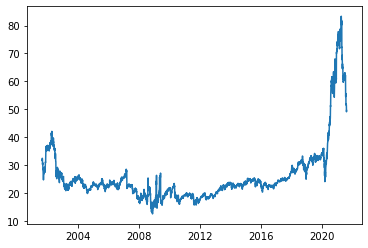

In [297]:
plt.plot(pe_ratio.PE)

In [298]:
# rename, change type
price = price.rename(columns = {"Dates": "Date", "S&P 500 Consumer Discretionary (Sector) (^SP500-25) - Index Value" : "Price"})
price['Date'] = pd.to_datetime(price['Date'])
price = price.set_index('Date')

price.head()

,Price
Date,
1989-09-11,77.33
1989-09-12,77.33
1989-09-13,76.32
1989-09-14,75.53
1989-09-15,75.66


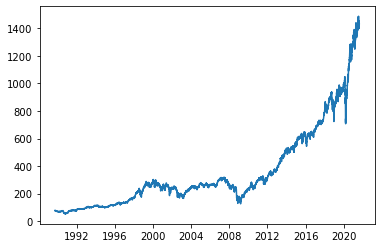

In [299]:
plt.plot(price.Price)

In [300]:
treasury = treasury.rename(columns = {"Value" : "treasury_rate"})
treasury.head()

,treasury_rate
Date,
1962-01-02,4.06
1962-01-03,4.03
1962-01-04,3.99
1962-01-05,4.02
1962-01-08,4.03


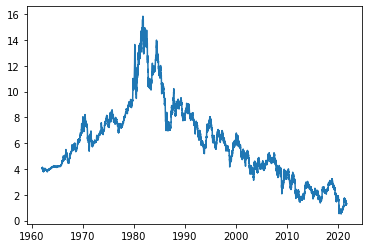

In [301]:
plt.plot(treasury.treasury_rate)

### Transform to monthly average

In [302]:
target_joined = pe_ratio.join(price).join(treasury)
target_joined.head()

,PE,Price,treasury_rate
Date,,,
2001-08-21,31.70,241.08,4.87
2001-08-22,31.80,241.63,4.91
2001-08-23,31.69,240.75,4.89
2001-08-24,32.48,246.84,4.93
2001-08-27,32.17,245.02,4.94


In [303]:
target_joined['month'] = target_joined.index.month
target_joined['year'] = target_joined.index.year

target_joined = target_joined.groupby([target_joined.year, target_joined.month]).mean()
target_joined.head()

PE       Price  treasury_rate
year month                                      
2001 8      31.516667  239.642222       4.867778
     9      27.175333  204.901333       4.748667
     10     28.268696  211.766087       4.566818
     11     33.669524  230.619524       4.651500
     12     36.054000  238.324500       5.087500

In [304]:
target_joined = target_joined.reset_index()
target_joined['date'] = pd.to_datetime(target_joined[['year', 'month']].assign(DAY=1))
target_joined = target_joined.set_index('date')
target_joined.head()

,year,month,PE,Price,treasury_rate
date,,,,,
2001-08-01,2001,8,31.516667,239.642222,4.867778
2001-09-01,2001,9,27.175333,204.901333,4.748667
2001-10-01,2001,10,28.268696,211.766087,4.566818
2001-11-01,2001,11,33.669524,230.619524,4.651500
2001-12-01,2001,12,36.054000,238.324500,5.087500


In [305]:
target_joined['earnings'] = target_joined.Price / target_joined.PE
target_joined.head()

,year,month,PE,Price,treasury_rate,earnings
date,,,,,,
2001-08-01,2001,8,31.516667,239.642222,4.867778,7.603666
2001-09-01,2001,9,27.175333,204.901333,4.748667,7.539975
2001-10-01,2001,10,28.268696,211.766087,4.566818,7.491187
2001-11-01,2001,11,33.669524,230.619524,4.651500,6.849504
2001-12-01,2001,12,36.054000,238.324500,5.087500,6.610210


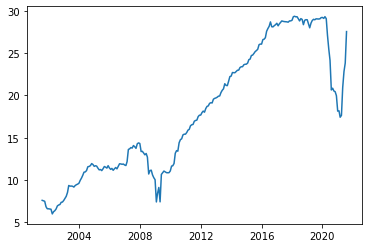

In [306]:
plt.plot(target_joined.earnings)

In [307]:
target_joined['earnings_change'] = target_joined.earnings.pct_change()
display(target_joined)

,year,month,PE,Price,treasury_rate,earnings,earnings_change
date,,,,,,,
2001-08-01,2001,8,31.516667,239.642222,4.867778,7.603666,NaN
2001-09-01,2001,9,27.175333,204.901333,4.748667,7.539975,-0.008376
2001-10-01,2001,10,28.268696,211.766087,4.566818,7.491187,-0.006471
2001-11-01,2001,11,33.669524,230.619524,4.651500,6.849504,-0.085658
2001-12-01,2001,12,36.054000,238.324500,5.087500,6.610210,-0.034936
...,...,...,...,...,...,...,...
2021-04-01,2021,4,80.362500,1417.672000,1.628000,17.640964,0.012511
2021-05-01,2021,5,65.739500,1376.421500,1.621000,20.937511,0.186869
2021-06-01,2021,6,60.907368,1390.399474,1.524211,22.828100,0.090297


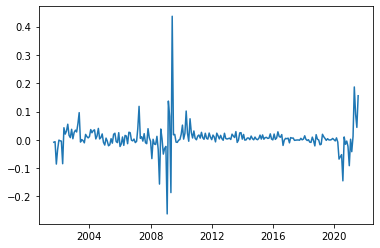

In [308]:
plt.plot(target_joined.earnings_change)

In [309]:
target_joined['target'] = target_joined.earnings_change - ((1 + target_joined.treasury_rate/100)**(1/12) - 1)
target_joined = target_joined.dropna()
target_joined.head()

,year,month,PE,Price,treasury_rate,earnings,earnings_change,target
date,,,,,,,,
2001-09-01,2001,9,27.175333,204.901333,4.748667,7.539975,-0.008376,-0.012250
2001-10-01,2001,10,28.268696,211.766087,4.566818,7.491187,-0.006471,-0.010199
2001-11-01,2001,11,33.669524,230.619524,4.651500,6.849504,-0.085658,-0.089454
2001-12-01,2001,12,36.054000,238.324500,5.087500,6.610210,-0.034936,-0.039080
2002-01-01,2002,1,36.128095,238.579524,5.035714,6.603712,-0.000983,-0.005086


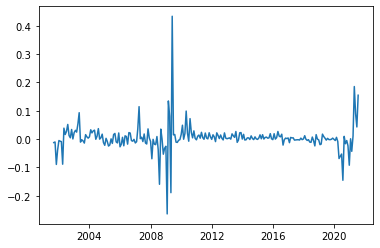

In [310]:
plt.plot(target_joined.target)

In [311]:
target = target_joined['target'].to_frame()
target.head()

,target
date,
2001-09-01,-0.012250
2001-10-01,-0.010199
2001-11-01,-0.089454
2001-12-01,-0.039080
2002-01-01,-0.005086


## Load exogenous Variables

In [21]:
def get_df_name(df):
    # grabs name of dataframe to be used as variable name
    name =[x for x in globals() if globals()[x] is df][0]
    return name

def var_change(df):
    # creates year on year and month on month growth rate columns
    df_name = get_df_name(df)
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['Date'] = pd.to_datetime(df[['year', 'month']].assign(DAY=1))
    df = df.set_index('Date')

    df = df.rename(columns = {'Value':df_name}).drop(columns = ['year', 'month'])

    df_mom_ch = df.rename(columns = {df_name : df_name + '_mom_ch'})
    df_mom_ch = df_mom_ch[df_name + '_mom_ch'].diff(1)/ df_mom_ch[df_name + '_mom_ch']

    df_yoy_ch = df.rename(columns = {df_name : df_name + '_yoy_ch'})
    df_yoy_ch = df_yoy_ch[df_name + '_yoy_ch'].diff(12)/ df_yoy_ch[df_name + '_yoy_ch']

    df_final = pd.DataFrame(df_mom_ch).join(df_yoy_ch).join(df)
    
    return df_final

## Load Quandl indicators

In [22]:
# PCEPILFE - Personal Consumption Expenditures Excluding Food and Energy (Chain-Type Price Index) 
pce = quandl.get('FRED/PCEPILFE')
pce.head()

,Value
Date,
1959-01-01,16.688
1959-02-01,16.701
1959-03-01,16.719
1959-04-01,16.762
1959-05-01,16.783


In [23]:
# CPIAUCSL - Consumer Price Index for All Urban Consumers: All Items in U.S. City Average 
cpi = quandl.get('FRED/CPIAUCSL')
cpi.head()

,Value
Date,
1947-01-01,21.48
1947-02-01,21.62
1947-03-01,22.00
1947-04-01,22.00
1947-05-01,21.95


In [24]:
# UNRATE - Unemployment Rate 
unemp = quandl.get('FRED/UNRATE')
unemp.head()

,Value
Date,
1948-01-01,3.4
1948-02-01,3.8
1948-03-01,4.0
1948-04-01,3.9
1948-05-01,3.5


In [25]:
# PAYEMS - All Employees, Total Nonfarm
emp = quandl.get('FRED/PAYEMS')
emp.head()

,Value
Date,
1939-01-01,29923.0
1939-02-01,30100.0
1939-03-01,30280.0
1939-04-01,30094.0
1939-05-01,30299.0


In [26]:
# RRSFS - Advance Real Retail and Food Services Sales
rrfs = quandl.get('FRED/RRSFS')
rrfs.head()

,Value
Date,
1992-01-01,118651.0
1992-02-01,118480.0
1992-03-01,117700.0
1992-04-01,118156.0
1992-05-01,118548.0


In [27]:
# RSXFS - Advance Retail Sales: Retail Trade
rsxfs = quandl.get('FRED/RSXFS')
rsxfs.head()

,Value
Date,
1992-01-01,146925.0
1992-02-01,147223.0
1992-03-01,146805.0
1992-04-01,148032.0
1992-05-01,149010.0


In [28]:
# SOC1 - Consumer Sentiment
soc = quandl.get('UMICH/SOC1').rename(columns = {'Index':'Value'})
soc.head()

,Value
Date,
1952-11-30,86.2
1953-02-28,90.7
1953-08-31,80.8
1953-11-30,80.7
1954-02-28,82.0


In [29]:
# FRED/VXTYN - CBOE 10-Year Treasury Note Volatility Futures
# https://fred.stlouisfed.org/series/VIXCLS#0
vix = pd.read_csv('../../data/raw/VIXCLS.csv').rename(columns = {'VIXCLS' : 'Value'})
vix['DATE'] = pd.to_datetime(vix['DATE'])
vix = vix.set_index('DATE')
vix.head()

,Value
DATE,
1990-01-01,23.347273
1990-02-01,23.262632
1990-03-01,20.062273
1990-04-01,21.403500
1990-05-01,18.097727


In [30]:
# FED/RXI_N_M_CH - CHINA -- SPOT EXCHANGE RATE, YUAN/US$, Monthly
usdcny = quandl.get('FED/RXI_N_M_CH')
usdcny.head()

,Value
Date,
1981-01-31,1.5518
1981-02-28,1.6131
1981-03-31,1.6314
1981-04-30,1.6660
1981-05-31,1.7270


In [31]:
# find month-on-month growth and year-on-year growth
emp_new = var_change(emp)
pce_new = var_change(pce)
cpi_new = var_change(cpi)
unemp_new = var_change(unemp)
rrfs_new = var_change(rrfs)
rsxfs_new = var_change(rsxfs)
soc_new = var_change(soc)
vix_new = var_change(vix)
usdcny_new = var_change(usdcny)

### Joined exogenous dataframe

In [36]:
# join all exogenous variables
ex_list = [emp_new, pce_new, cpi_new, unemp_new, rrfs_new, rsxfs_new, soc_new, vix_new, usdcny_new]
ex_merged = reduce(lambda  left, right: pd.merge(left, right, left_index=True, right_index=True, how='outer'), ex_list)
ex_merged.head()

,emp_mom_ch,emp_yoy_ch,emp,pce_mom_ch,pce_yoy_ch,pce,cpi_mom_ch,cpi_yoy_ch,cpi,unemp_mom_ch,...,rsxfs,soc_mom_ch,soc_yoy_ch,soc,vix_mom_ch,vix_yoy_ch,vix,usdcny_mom_ch,usdcny_yoy_ch,usdcny
Date,,,,,,,,,,,,,,,,,,,,,
1939-01-01,NaN,NaN,29923.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1939-02-01,0.005880,NaN,30100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1939-03-01,0.005945,NaN,30280.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1939-04-01,-0.006181,NaN,30094.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1939-05-01,0.006766,NaN,30299.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
ex_final = ex_merged
ex_final.columns

Index(['emp_mom_ch', 'emp_yoy_ch', 'emp', 'pce_mom_ch', 'pce_yoy_ch', 'pce',
       'cpi_mom_ch', 'cpi_yoy_ch', 'cpi', 'unemp_mom_ch', 'unemp_yoy_ch',
       'unemp', 'rrfs_mom_ch', 'rrfs_yoy_ch', 'rrfs', 'rsxfs_mom_ch',
       'rsxfs_yoy_ch', 'rsxfs', 'soc_mom_ch', 'soc_yoy_ch', 'soc',
       'vix_mom_ch', 'vix_yoy_ch', 'vix', 'usdcny_mom_ch', 'usdcny_yoy_ch',
       'usdcny'],
      dtype='object')

### Create feature lags

In [38]:
# this lags features in ex_columns in the range of periods in lag_periods

ex_columns = ['emp_mom_ch', 'emp_yoy_ch', 'emp', 'pce_mom_ch', 'pce_yoy_ch', 'pce',
       'cpi_mom_ch', 'cpi_yoy_ch', 'cpi', 'unemp_mom_ch', 'unemp_yoy_ch',
       'unemp', 'rrfs_mom_ch', 'rrfs_yoy_ch', 'rrfs', 'rsxfs_mom_ch',
       'rsxfs_yoy_ch', 'rsxfs', 'soc_mom_ch', 'soc_yoy_ch', 'soc',
       'vix_mom_ch', 'vix_yoy_ch', 'vix',  'usdcny_mom_ch', 'usdcny_yoy_ch',
       'usdcny']

lag_periods = list(range(1,14))
def add_lags(var_names, lag_periods):
    for var in var_names:
        for lag in lag_periods:
            var_col = var + '_' + str(lag)
            ex_final[var_col] = ex_final[var].shift(lag)
            
add_lags(ex_columns, lag_periods)

<ipython-input-38-003879ab145d>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  ex_final[var_col] = ex_final[var].shift(lag)


## Join with target variable

In [313]:
# join all exogenous variables
final_join_list = [target, ex_final]
final_df = reduce(lambda  left, right: pd.merge(left, right, left_index=True, right_index=True, how='outer'), final_join_list)
final_df

,target,emp_mom_ch,emp_yoy_ch,emp,pce_mom_ch,pce_yoy_ch,pce,cpi_mom_ch,cpi_yoy_ch,cpi,...,usdcny_4,usdcny_5,usdcny_6,usdcny_7,usdcny_8,usdcny_9,usdcny_10,usdcny_11,usdcny_12,usdcny_13
1939-01-01,NaN,NaN,NaN,29923.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1939-02-01,NaN,0.005880,NaN,30100.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1939-03-01,NaN,0.005945,NaN,30280.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1939-04-01,NaN,-0.006181,NaN,30094.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1939-05-01,NaN,0.006766,NaN,30299.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-01,0.011165,0.001864,0.098146,144326.0,0.006236,0.029964,116.107,0.007642,0.039875,266.832,...,6.5393,6.6029,6.7254,6.8106,6.9270,7.0041,7.0816,7.1016,7.0708,7.0205
2021-05-01,0.185528,0.004236,0.082420,144940.0,0.005720,0.033492,116.775,0.006401,0.046952,268.551,...,6.4672,6.5393,6.6029,6.7254,6.8106,6.9270,7.0041,7.0816,7.1016,7.0708
2021-06-01,0.089035,0.006430,0.055101,145878.0,0.004679,0.034597,117.324,0.008967,0.050553,270.981,...,6.4601,6.4672,6.5393,6.6029,6.7254,6.8106,6.9270,7.0041,7.0816,7.1016
2021-07-01,0.042853,0.006423,0.049414,146821.0,0.003364,0.034913,117.720,0.004716,0.050175,272.265,...,6.5109,6.4601,6.4672,6.5393,6.6029,6.7254,6.8106,6.9270,7.0041,7.0816


In [326]:
# look at any NAs
final_df[final_df.isna().any(1)]

,target,emp_mom_ch,emp_yoy_ch,emp,pce_mom_ch,pce_yoy_ch,pce,cpi_mom_ch,cpi_yoy_ch,cpi,...,usdcny_4,usdcny_5,usdcny_6,usdcny_7,usdcny_8,usdcny_9,usdcny_10,usdcny_11,usdcny_12,usdcny_13
1939-01-01,NaN,NaN,NaN,29923.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1939-02-01,NaN,0.005880,NaN,30100.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1939-03-01,NaN,0.005945,NaN,30280.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1939-04-01,NaN,-0.006181,NaN,30094.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1939-05-01,NaN,0.006766,NaN,30299.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2001-05-01,NaN,-0.000400,0.002303,132410.0,0.000232,0.019044,81.970,0.005076,0.034405,177.3,...,8.2776,8.2771,8.2774,8.2785,8.2785,8.2796,8.2794,8.2772,8.2781,8.2793
2001-06-01,NaN,-0.000839,0.001799,132299.0,0.002240,0.020498,82.154,0.002251,0.030951,177.7,...,8.2771,8.2776,8.2771,8.2774,8.2785,8.2785,8.2796,8.2794,8.2772,8.2781
2001-07-01,NaN,-0.000923,-0.000446,132177.0,0.002574,0.020785,82.366,-0.001691,0.026494,177.4,...,8.2775,8.2771,8.2776,8.2771,8.2774,8.2785,8.2785,8.2796,8.2794,8.2772
2001-08-01,NaN,-0.001129,-0.001530,132028.0,0.000485,0.020011,82.406,0.000000,0.026494,177.4,...,8.2771,8.2775,8.2771,8.2776,8.2771,8.2774,8.2785,8.2785,8.2796,8.2794


In [333]:
# remove latest periods with missing data
#df = final_df.iloc[:-1]
#df.tail()
df = final_df
df.index = df.index.rename('date')
df

,target,emp_mom_ch,emp_yoy_ch,emp,pce_mom_ch,pce_yoy_ch,pce,cpi_mom_ch,cpi_yoy_ch,cpi,...,usdcny_4,usdcny_5,usdcny_6,usdcny_7,usdcny_8,usdcny_9,usdcny_10,usdcny_11,usdcny_12,usdcny_13
date,,,,,,,,,,,,,,,,,,,,,
1939-01-01,NaN,NaN,NaN,29923.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1939-02-01,NaN,0.005880,NaN,30100.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1939-03-01,NaN,0.005945,NaN,30280.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1939-04-01,NaN,-0.006181,NaN,30094.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1939-05-01,NaN,0.006766,NaN,30299.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-01,0.011165,0.001864,0.098146,144326.0,0.006236,0.029964,116.107,0.007642,0.039875,266.832,...,6.5393,6.6029,6.7254,6.8106,6.9270,7.0041,7.0816,7.1016,7.0708,7.0205
2021-05-01,0.185528,0.004236,0.082420,144940.0,0.005720,0.033492,116.775,0.006401,0.046952,268.551,...,6.4672,6.5393,6.6029,6.7254,6.8106,6.9270,7.0041,7.0816,7.1016,7.0708
2021-06-01,0.089035,0.006430,0.055101,145878.0,0.004679,0.034597,117.324,0.008967,0.050553,270.981,...,6.4601,6.4672,6.5393,6.6029,6.7254,6.8106,6.9270,7.0041,7.0816,7.1016


## Feature Correlation

In [315]:
var_corr = (df.corr().sort_values('target'))
var_corr.tail()

,target,emp_mom_ch,emp_yoy_ch,emp,pce_mom_ch,pce_yoy_ch,pce,cpi_mom_ch,cpi_yoy_ch,cpi,...,usdcny_4,usdcny_5,usdcny_6,usdcny_7,usdcny_8,usdcny_9,usdcny_10,usdcny_11,usdcny_12,usdcny_13
unemp_13,0.273531,0.082147,0.338650,-0.368280,0.062922,0.024237,-0.006667,0.054616,0.083211,0.045151,...,-0.394214,-0.390777,-0.385432,-0.377431,-0.368295,-0.357535,-0.347116,-0.336689,-0.327990,-0.321813
soc_yoy_ch_2,0.281774,-0.036678,0.301598,0.015668,-0.051356,-0.043807,0.053376,-0.004537,-0.223925,0.047175,...,-0.166649,-0.177730,-0.189073,-0.202673,-0.216117,-0.228769,-0.237113,-0.242382,-0.247366,-0.252132
soc_yoy_ch,0.297678,0.141560,0.384134,0.021343,0.098757,-0.003421,0.053212,0.018592,-0.273988,0.045037,...,-0.182578,-0.196609,-0.210046,-0.222459,-0.230361,-0.235022,-0.239412,-0.243567,-0.247161,-0.251997
soc_yoy_ch_1,0.315977,0.020785,0.373184,0.024333,-0.049467,-0.023361,0.052882,0.025561,-0.240509,0.046138,...,-0.174180,-0.185805,-0.199509,-0.212849,-0.225423,-0.233469,-0.238531,-0.243191,-0.247754,-0.251609
target,1.000000,-0.016757,0.188015,-0.069599,0.040804,0.068764,-0.041159,0.117952,-0.016361,-0.037562,...,-0.024834,-0.026668,-0.027943,-0.029220,-0.031766,-0.031230,-0.028269,-0.028216,-0.026636,-0.022342


In [316]:
var_corr.head()

,target,emp_mom_ch,emp_yoy_ch,emp,pce_mom_ch,pce_yoy_ch,pce,cpi_mom_ch,cpi_yoy_ch,cpi,...,usdcny_4,usdcny_5,usdcny_6,usdcny_7,usdcny_8,usdcny_9,usdcny_10,usdcny_11,usdcny_12,usdcny_13
cpi_mom_ch_7,-0.341393,0.012087,0.102226,-0.014055,0.028210,0.253004,-0.081955,-0.034477,0.338537,-0.073689,...,0.108283,0.109261,0.111559,0.118494,0.132856,0.143907,0.148731,0.149244,0.148873,0.149236
emp_yoy_ch_13,-0.303704,-0.031476,-0.040431,0.329196,-0.169804,-0.145790,0.092194,-0.155156,-0.170427,0.089815,...,-0.051825,-0.053798,-0.059118,-0.067923,-0.076884,-0.087337,-0.096431,-0.104867,-0.109954,-0.111023
unemp_yoy_ch_1,-0.278357,-0.030037,-0.807647,-0.304128,-0.138041,-0.490707,-0.175265,-0.086718,-0.328083,-0.187513,...,0.208238,0.212165,0.214288,0.214050,0.212419,0.207315,0.200629,0.195060,0.191590,0.191061
emp_yoy_ch_12,-0.264732,-0.026432,-0.084467,0.306614,-0.248012,-0.172357,0.064553,-0.175122,-0.165840,0.064960,...,-0.044263,-0.048233,-0.056789,-0.066845,-0.078177,-0.089398,-0.099213,-0.106390,-0.108852,-0.107656
unemp_yoy_ch,-0.264545,-0.195173,-0.899752,-0.307949,-0.294567,-0.538626,-0.193734,-0.169440,-0.351934,-0.204536,...,0.214399,0.217536,0.217300,0.214503,0.208466,0.199781,0.192867,0.187414,0.185564,0.187235


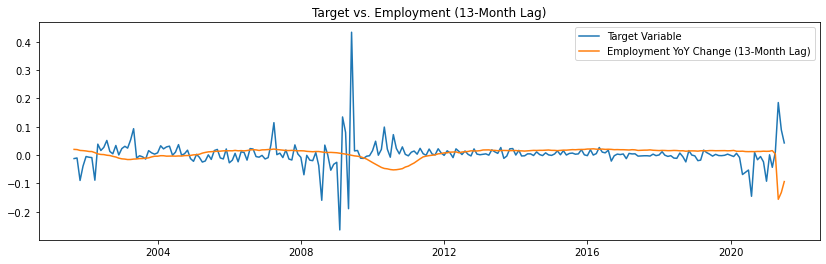

In [317]:
plt.figure(figsize = (14, 4))
plt.plot(df.target, label = 'Target Variable')
plt.plot(df.emp_yoy_ch_13, label = 'Employment YoY Change (13-Month Lag)')
plt.title('Target vs. Employment (13-Month Lag)')
plt.legend()

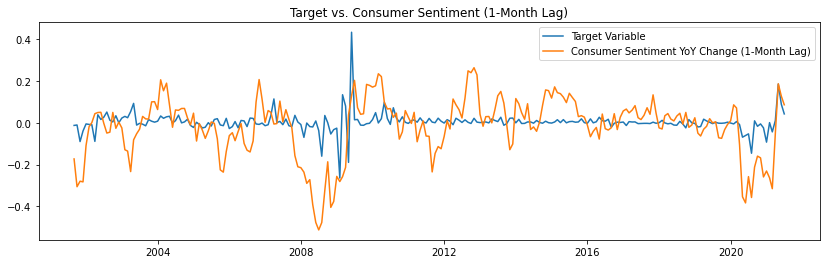

In [318]:
plt.figure(figsize = (14, 4))
plt.plot(df.target, label = 'Target Variable')
plt.plot(df.soc_yoy_ch_1, label = 'Consumer Sentiment YoY Change (1-Month Lag)')
plt.title('Target vs. Consumer Sentiment (1-Month Lag)')
plt.legend()

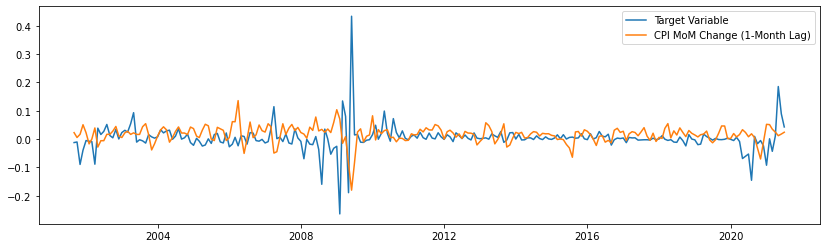

In [319]:
plt.figure(figsize = (14, 4))
plt.plot(df.target, label = 'Target Variable')
plt.plot(df.cpi_mom_ch_7*10, label = 'CPI MoM Change (1-Month Lag)')
plt.legend()

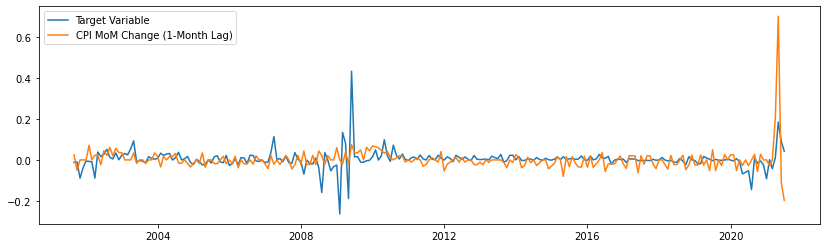

In [322]:
plt.figure(figsize = (14, 4))
plt.plot(df.target, label = 'Target Variable')
plt.plot(df.unemp_mom_ch_13, label = 'CPI MoM Change (1-Month Lag)')
plt.legend()

Notes:
- we would include highest and lowest correlation features
- in 1-2 months ahead, soc and unemp have large correlation
- around half year: cpi has large correlation
- 10-plus periods: unemp and emp 

## Shift target variables for 1, 3, 6, 12, 18 months

In [345]:
df_1 = df
df_1 = df_1.reset_index()
df_1['target'] = df_1.target.shift(-1)
df_1['date'] = df_1.date + pd.DateOffset(months = 1)
df_1 = df_1.set_index('date')
df_1 = df_1[df_1.index >= target.index[0]]
df_1['month'] = df_1.index.month
df_1

,target,emp_mom_ch,emp_yoy_ch,emp,pce_mom_ch,pce_yoy_ch,pce,cpi_mom_ch,cpi_yoy_ch,cpi,...,usdcny_5,usdcny_6,usdcny_7,usdcny_8,usdcny_9,usdcny_10,usdcny_11,usdcny_12,usdcny_13,month
date,,,,,,,,,,,,,,,,,,,,,
2001-09-01,-0.012250,-0.001129,-0.001530,132028.0,0.000485,0.020011,82.406,0.000000,0.026494,177.400,...,8.2775,8.2771,8.2776,8.2771,8.2774,8.2785,8.2785,8.2796,8.2794,9
2001-10-01,-0.010199,-0.001950,-0.004417,131771.0,-0.005699,0.012033,81.939,0.003930,0.025267,178.100,...,8.2771,8.2775,8.2771,8.2776,8.2771,8.2774,8.2785,8.2785,8.2796,10
2001-11-01,-0.089454,-0.002411,-0.006824,131454.0,0.006993,0.017560,82.516,-0.002815,0.020833,177.600,...,8.2770,8.2771,8.2775,8.2771,8.2776,8.2771,8.2774,8.2785,8.2785,11
2001-12-01,-0.039080,-0.002379,-0.010782,131142.0,0.002020,0.017815,82.683,-0.000563,0.018592,177.500,...,8.2770,8.2770,8.2771,8.2775,8.2771,8.2776,8.2771,8.2774,8.2785,12
2002-01-01,-0.005086,-0.001222,-0.013185,130982.0,0.000230,0.017085,82.702,-0.000564,0.015784,177.400,...,8.2769,8.2770,8.2770,8.2771,8.2775,8.2771,8.2776,8.2771,8.2774,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-01,0.185528,0.001864,0.098146,144326.0,0.006236,0.029964,116.107,0.007642,0.039875,266.832,...,6.6029,6.7254,6.8106,6.9270,7.0041,7.0816,7.1016,7.0708,7.0205,5
2021-06-01,0.089035,0.004236,0.082420,144940.0,0.005720,0.033492,116.775,0.006401,0.046952,268.551,...,6.5393,6.6029,6.7254,6.8106,6.9270,7.0041,7.0816,7.1016,7.0708,6
2021-07-01,0.042853,0.006430,0.055101,145878.0,0.004679,0.034597,117.324,0.008967,0.050553,270.981,...,6.4672,6.5393,6.6029,6.7254,6.8106,6.9270,7.0041,7.0816,7.1016,7


In [346]:
df_3 = df
df_3 = df_3.reset_index()
df_3['target'] = df_3.target.shift(-3)
df_3['date'] = df_3.date + pd.DateOffset(months = 3)
df_3 = df_3.set_index('date')
df_3 = df_3[df_3.index >= target.index[0]]
df_3['month'] = df_3.index.month
df_3

,target,emp_mom_ch,emp_yoy_ch,emp,pce_mom_ch,pce_yoy_ch,pce,cpi_mom_ch,cpi_yoy_ch,cpi,...,usdcny_5,usdcny_6,usdcny_7,usdcny_8,usdcny_9,usdcny_10,usdcny_11,usdcny_12,usdcny_13,month
date,,,,,,,,,,,,,,,,,,,,,
2001-09-01,-0.012250,-0.000839,0.001799,132299.0,0.002240,0.020498,82.154,0.002251,0.030951,177.700,...,8.2776,8.2771,8.2774,8.2785,8.2785,8.2796,8.2794,8.2772,8.2781,9
2001-10-01,-0.010199,-0.000923,-0.000446,132177.0,0.002574,0.020785,82.366,-0.001691,0.026494,177.400,...,8.2771,8.2776,8.2771,8.2774,8.2785,8.2785,8.2796,8.2794,8.2772,10
2001-11-01,-0.089454,-0.001129,-0.001530,132028.0,0.000485,0.020011,82.406,0.000000,0.026494,177.400,...,8.2775,8.2771,8.2776,8.2771,8.2774,8.2785,8.2785,8.2796,8.2794,11
2001-12-01,-0.039080,-0.001950,-0.004417,131771.0,-0.005699,0.012033,81.939,0.003930,0.025267,178.100,...,8.2771,8.2775,8.2771,8.2776,8.2771,8.2774,8.2785,8.2785,8.2796,12
2002-01-01,-0.005086,-0.002411,-0.006824,131454.0,0.006993,0.017560,82.516,-0.002815,0.020833,177.600,...,8.2770,8.2771,8.2775,8.2771,8.2776,8.2771,8.2774,8.2785,8.2785,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-01,0.042853,0.001864,0.098146,144326.0,0.006236,0.029964,116.107,0.007642,0.039875,266.832,...,6.6029,6.7254,6.8106,6.9270,7.0041,7.0816,7.1016,7.0708,7.0205,7
2021-08-01,0.154848,0.004236,0.082420,144940.0,0.005720,0.033492,116.775,0.006401,0.046952,268.551,...,6.5393,6.6029,6.7254,6.8106,6.9270,7.0041,7.0816,7.1016,7.0708,8
2021-09-01,NaN,0.006430,0.055101,145878.0,0.004679,0.034597,117.324,0.008967,0.050553,270.981,...,6.4672,6.5393,6.6029,6.7254,6.8106,6.9270,7.0041,7.0816,7.1016,9


In [347]:
df_6 = df
df_6 = df_6.reset_index()
df_6['target'] = df_6.target.shift(-6)
df_6['date'] = df_6.date + pd.DateOffset(months = 6)
df_6 = df_6.set_index('date')
df_6 = df_6[df_6.index >= target.index[0]]
df_6['month'] = df_6.index.month
df_6

,target,emp_mom_ch,emp_yoy_ch,emp,pce_mom_ch,pce_yoy_ch,pce,cpi_mom_ch,cpi_yoy_ch,cpi,...,usdcny_5,usdcny_6,usdcny_7,usdcny_8,usdcny_9,usdcny_10,usdcny_11,usdcny_12,usdcny_13,month
date,,,,,,,,,,,,,,,,,,,,,
2001-09-01,-0.012250,-0.000316,0.008671,132747.0,0.001039,0.018956,81.821,0.000568,0.028961,176.100,...,8.2785,8.2785,8.2796,8.2794,8.2772,8.2781,8.2793,8.2786,8.2781,9
2001-10-01,-0.010199,-0.002144,0.004341,132463.0,0.001586,0.019866,81.951,0.001701,0.031179,176.400,...,8.2774,8.2785,8.2785,8.2796,8.2794,8.2772,8.2781,8.2793,8.2786,10
2001-11-01,-0.089454,-0.000400,0.002303,132410.0,0.000232,0.019044,81.970,0.005076,0.034405,177.300,...,8.2771,8.2774,8.2785,8.2785,8.2796,8.2794,8.2772,8.2781,8.2793,11
2001-12-01,-0.039080,-0.000839,0.001799,132299.0,0.002240,0.020498,82.154,0.002251,0.030951,177.700,...,8.2776,8.2771,8.2774,8.2785,8.2785,8.2796,8.2794,8.2772,8.2781,12
2002-01-01,-0.005086,-0.000923,-0.000446,132177.0,0.002574,0.020785,82.366,-0.001691,0.026494,177.400,...,8.2771,8.2776,8.2771,8.2774,8.2785,8.2785,8.2796,8.2794,8.2772,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-01,NaN,0.001864,0.098146,144326.0,0.006236,0.029964,116.107,0.007642,0.039875,266.832,...,6.6029,6.7254,6.8106,6.9270,7.0041,7.0816,7.1016,7.0708,7.0205,10
2021-11-01,NaN,0.004236,0.082420,144940.0,0.005720,0.033492,116.775,0.006401,0.046952,268.551,...,6.5393,6.6029,6.7254,6.8106,6.9270,7.0041,7.0816,7.1016,7.0708,11
2021-12-01,NaN,0.006430,0.055101,145878.0,0.004679,0.034597,117.324,0.008967,0.050553,270.981,...,6.4672,6.5393,6.6029,6.7254,6.8106,6.9270,7.0041,7.0816,7.1016,12


In [348]:
df_12 = df
df_12 = df_12.reset_index()
df_12['target'] = df_12.target.shift(-12)
df_12['date'] = df_12.date + pd.DateOffset(months = 12)
df_12 = df_12.set_index('date')
df_12 = df_12[df_12.index >= target.index[0]]
df_12['month'] = df_12.index.month
df_12

,target,emp_mom_ch,emp_yoy_ch,emp,pce_mom_ch,pce_yoy_ch,pce,cpi_mom_ch,cpi_yoy_ch,cpi,...,usdcny_5,usdcny_6,usdcny_7,usdcny_8,usdcny_9,usdcny_10,usdcny_11,usdcny_12,usdcny_13,month
date,,,,,,,,,,,,,,,,,,,,,
2001-09-01,-0.012250,0.000929,0.019501,132353.0,0.002421,0.018159,80.953,0.005184,0.033410,173.600,...,8.2793,8.2786,8.2781,8.2792,8.2794,8.2782,8.2775,8.2774,8.2772,9
2001-10-01,-0.010199,-0.000015,0.016426,132351.0,0.001406,0.017862,81.067,0.001725,0.033353,173.900,...,8.2781,8.2793,8.2786,8.2781,8.2792,8.2794,8.2782,8.2775,8.2774,10
2001-11-01,-0.089454,0.001547,0.015767,132556.0,0.001761,0.018655,81.210,0.001722,0.033295,174.200,...,8.2772,8.2781,8.2793,8.2786,8.2781,8.2792,8.2794,8.2782,8.2775,11
2001-12-01,-0.039080,0.001153,0.014596,132709.0,0.000972,0.018367,81.289,0.002291,0.033219,174.600,...,8.2794,8.2772,8.2781,8.2793,8.2786,8.2781,8.2792,8.2794,8.2782,12
2002-01-01,-0.005086,-0.000083,0.012758,132698.0,0.003714,0.019671,81.592,0.005695,0.035877,175.600,...,8.2796,8.2794,8.2772,8.2781,8.2793,8.2786,8.2781,8.2792,8.2794,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-01,NaN,0.001864,0.098146,144326.0,0.006236,0.029964,116.107,0.007642,0.039875,266.832,...,6.6029,6.7254,6.8106,6.9270,7.0041,7.0816,7.1016,7.0708,7.0205,4
2022-05-01,NaN,0.004236,0.082420,144940.0,0.005720,0.033492,116.775,0.006401,0.046952,268.551,...,6.5393,6.6029,6.7254,6.8106,6.9270,7.0041,7.0816,7.1016,7.0708,5
2022-06-01,NaN,0.006430,0.055101,145878.0,0.004679,0.034597,117.324,0.008967,0.050553,270.981,...,6.4672,6.5393,6.6029,6.7254,6.8106,6.9270,7.0041,7.0816,7.1016,6


In [349]:
df_18 = df
df_18 = df_18.reset_index()
df_18['target'] = df_18.target.shift(-18)
df_18['date'] = df_18.date + pd.DateOffset(months = 18)
df_18 = df_18.set_index('date')
df_18 = df_18[df_18.index >= target.index[0]]
df_18['month'] = df_18.index.month
df_18

,target,emp_mom_ch,emp_yoy_ch,emp,pce_mom_ch,pce_yoy_ch,pce,cpi_mom_ch,cpi_yoy_ch,cpi,...,usdcny_5,usdcny_6,usdcny_7,usdcny_8,usdcny_9,usdcny_10,usdcny_11,usdcny_12,usdcny_13,month
date,,,,,,,,,,,,,,,,,,,,,
2001-09-01,-0.012250,0.003587,0.025601,131596.0,0.002043,0.018650,80.270,0.005848,0.036257,171.000,...,8.2775,8.2774,8.2772,8.2776,8.2780,8.2785,8.2792,8.2792,8.2781,9
2001-10-01,-0.010199,0.002214,0.024953,131888.0,0.000660,0.016782,80.323,-0.000585,0.029257,170.900,...,8.2782,8.2775,8.2774,8.2772,8.2776,8.2780,8.2785,8.2792,8.2792,10
2001-11-01,-0.089454,0.001643,0.024957,132105.0,0.001070,0.016889,80.409,0.001752,0.030374,171.200,...,8.2794,8.2782,8.2775,8.2774,8.2772,8.2776,8.2780,8.2785,8.2792,11
2001-12-01,-0.039080,-0.000333,0.022505,132061.0,0.000758,0.017124,80.470,0.005807,0.036005,172.200,...,8.2792,8.2794,8.2782,8.2775,8.2774,8.2772,8.2776,8.2780,8.2785,12
2002-01-01,-0.005086,0.001323,0.021341,132236.0,0.002281,0.017594,80.654,0.002895,0.034742,172.700,...,8.2781,8.2792,8.2794,8.2782,8.2775,8.2774,8.2772,8.2776,8.2780,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-01,NaN,0.001864,0.098146,144326.0,0.006236,0.029964,116.107,0.007642,0.039875,266.832,...,6.6029,6.7254,6.8106,6.9270,7.0041,7.0816,7.1016,7.0708,7.0205,10
2022-11-01,NaN,0.004236,0.082420,144940.0,0.005720,0.033492,116.775,0.006401,0.046952,268.551,...,6.5393,6.6029,6.7254,6.8106,6.9270,7.0041,7.0816,7.1016,7.0708,11
2022-12-01,NaN,0.006430,0.055101,145878.0,0.004679,0.034597,117.324,0.008967,0.050553,270.981,...,6.4672,6.5393,6.6029,6.7254,6.8106,6.9270,7.0041,7.0816,7.1016,12


# Model

In [155]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")
import pmdarima as pm
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from PlotForecast import plot_forecast

## SARIMA Model - 1 month

In [220]:
var_corr_1 = (df_1.corr().sort_values('target'))
var_corr_1.head()

,target,emp_mom_ch,emp_yoy_ch,emp,pce_mom_ch,pce_yoy_ch,pce,cpi_mom_ch,cpi_yoy_ch,cpi,...,usdcny_4,usdcny_5,usdcny_6,usdcny_7,usdcny_8,usdcny_9,usdcny_10,usdcny_11,usdcny_12,usdcny_13
cpi_mom_ch_6,-0.341215,-0.037021,0.095306,-0.014068,0.029823,0.248652,-0.078196,-0.058218,0.334762,-0.068598,...,0.107351,0.109540,0.116502,0.131054,0.142267,0.147351,0.148026,0.147864,0.148357,0.150261
emp_yoy_ch_12,-0.303139,-0.026432,-0.084467,0.306614,-0.248012,-0.172357,0.064553,-0.175122,-0.165840,0.064960,...,-0.044263,-0.048233,-0.056789,-0.066845,-0.078177,-0.089398,-0.099213,-0.106390,-0.108852,-0.107656
unemp_yoy_ch,-0.277732,-0.195173,-0.899752,-0.307949,-0.294567,-0.538626,-0.193734,-0.169440,-0.351934,-0.204536,...,0.214399,0.217536,0.217300,0.214503,0.208466,0.199781,0.192867,0.187414,0.185564,0.187235
emp_yoy_ch_11,-0.264140,-0.027026,0.042005,0.289350,-0.249619,-0.121776,0.043971,-0.178346,-0.127304,0.046654,...,-0.040909,-0.048274,-0.058129,-0.070390,-0.082390,-0.094049,-0.102461,-0.106772,-0.106806,-0.104897
soc_12,-0.241809,-0.014458,0.013226,0.469737,0.043550,0.219143,0.086361,0.047809,0.209020,0.030466,...,0.377214,0.372920,0.367063,0.359977,0.349958,0.339042,0.326565,0.313325,0.300681,0.288468


In [221]:
var_corr_1.tail()

,target,emp_mom_ch,emp_yoy_ch,emp,pce_mom_ch,pce_yoy_ch,pce,cpi_mom_ch,cpi_yoy_ch,cpi,...,usdcny_4,usdcny_5,usdcny_6,usdcny_7,usdcny_8,usdcny_9,usdcny_10,usdcny_11,usdcny_12,usdcny_13
unemp_yoy_ch_12,0.261520,-0.005284,-0.129037,-0.449728,0.156438,0.057624,-0.236245,0.124712,0.094992,-0.238341,...,0.186432,0.190363,0.196878,0.206907,0.216620,0.226128,0.234381,0.241503,0.245075,0.246459
unemp_12,0.272797,0.079840,0.366343,-0.374354,0.126824,0.042965,0.003218,0.082895,0.090461,0.053293,...,-0.389957,-0.385201,-0.377243,-0.367522,-0.356256,-0.344717,-0.333523,-0.323709,-0.316804,-0.312031
soc_yoy_ch_1,0.281039,0.020785,0.373184,0.024333,-0.049467,-0.023361,0.052882,0.025561,-0.240509,0.046138,...,-0.174180,-0.185805,-0.199509,-0.212849,-0.225423,-0.233469,-0.238531,-0.243191,-0.247754,-0.251609
soc_yoy_ch,0.315334,0.141560,0.384134,0.021343,0.098757,-0.003421,0.053212,0.018592,-0.273988,0.045037,...,-0.182578,-0.196609,-0.210046,-0.222459,-0.230361,-0.235022,-0.239412,-0.243567,-0.247161,-0.251997
target,1.000000,0.074358,0.211680,-0.067156,0.061572,0.068589,-0.044427,0.069483,-0.012983,-0.043607,...,-0.024722,-0.026022,-0.027323,-0.029897,-0.029376,-0.026418,-0.026379,-0.024808,-0.020509,-0.023882


In [537]:
model_exvar = ['soc_yoy_ch_1', 'emp_yoy_ch_12']

# train test split
split_date = pd.Timestamp('2017-01-01')

train = df_1.loc[:split_date]
y_train = train['target']
x_train = train[model_exvar]

test =  df_1.loc[(split_date + relativedelta(months = 1)):]
y_test = test['target']
x_test = test[model_exvar]

In [352]:
# Find p, q for sarimax model
#results = pm.auto_arima(y_train, seasonal = True, m = 12, D = 1, information_criterion = 'aic', exogenous = np.array(x_train))
#print(results.summary())

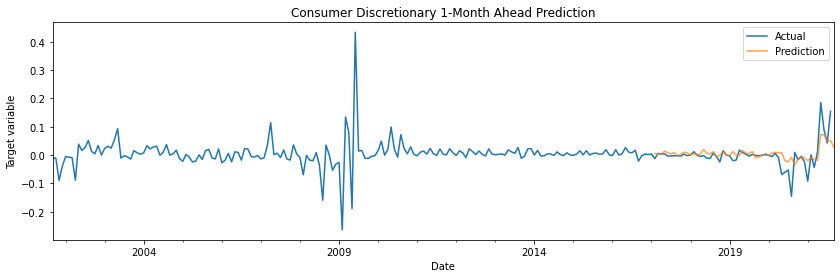

MAPE: 1.884
MAE: 0.018


In [538]:
# use orders from auto arima above
sar1_model = SARIMAX(y_train, 
                order = (3,0,0), 
                seasonal_order = (2,1,0,12)
                , exog = x_train
                )

sar1_mod_fit = sar1_model.fit()

sar1_pred = sar1_mod_fit.get_prediction(start = y_test.index[0], end = y_test.index[-1], exog = x_test)

sar1_pred_mean = sar1_pred.predicted_mean
sar1_pred_ci = sar1_pred.conf_int(alpha = 0.5)
ax = df_1.target.plot(label='Actual')
sar1_pred_mean.plot(ax=ax, label='Prediction', alpha=.7, figsize=(14, 4))
ax.set_xlabel('Date')
ax.set_ylabel('Target variable')
plt.title('Consumer Discretionary 1-Month Ahead Prediction')
plt.legend()
plt.show()

last_date = y_test.dropna().index[-1]

print("MAPE:", round(mape(y_test[y_test.index < last_date], sar1_pred_mean[sar1_pred_mean.index < last_date]), 3))
print("MAE:", round(mae(y_test[y_test.index < last_date], sar1_pred_mean[sar1_pred_mean.index < last_date]), 3))

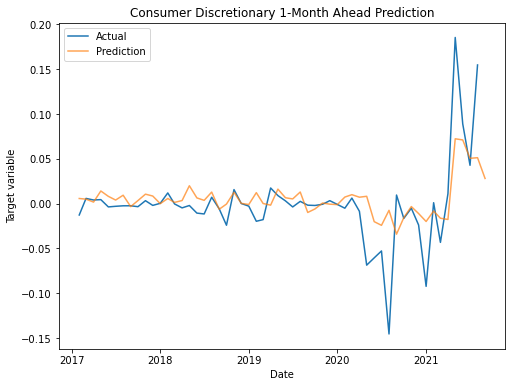

In [539]:
first_date = y_test.index[0]
last_date = y_test.dropna().index[-1]


fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(df_1[df_1.index >= first_date].index, df_1[df_1.index >= first_date].target, label = 'Actual')
ax.plot(sar1_pred_mean.index, sar1_pred_mean, label='Prediction', alpha=.7)
ax.set_xlabel('Date')
ax.set_ylabel('Target variable')
plt.title('Consumer Discretionary 1-Month Ahead Prediction')
plt.legend()
plt.show()

## SARIMAX Model - 3 month

In [118]:
var_corr_3 = (df_3.corr().sort_values('target'))
var_corr_3.head()

,target,emp_mom_ch,emp_yoy_ch,emp,pce_mom_ch,pce_yoy_ch,pce,cpi_mom_ch,cpi_yoy_ch,cpi,...,usdcny_5,usdcny_6,usdcny_7,usdcny_8,usdcny_9,usdcny_10,usdcny_11,usdcny_12,usdcny_13,month
cpi_mom_ch_4,-0.344482,0.015249,0.129000,-0.004341,-0.041192,0.278540,-0.085207,-0.034077,0.343155,-0.072186,...,0.135679,0.146840,0.151682,0.152157,0.151741,0.152068,0.153826,0.156245,0.156385,-0.055308
emp_yoy_ch_10,-0.301137,-0.006210,0.283998,0.353372,-0.088265,0.131549,0.116600,-0.101322,0.024043,0.120568,...,-0.089401,-0.099888,-0.108994,-0.117434,-0.122479,-0.123450,-0.120615,-0.116927,-0.112431,0.010555
emp_yoy_ch_9,-0.262040,-0.000131,0.364768,0.329217,-0.079265,0.161246,0.087271,-0.084591,0.063592,0.094114,...,-0.089486,-0.100759,-0.110605,-0.117774,-0.120161,-0.118844,-0.115527,-0.110408,-0.110489,0.031421
emp_mom_ch_10,-0.234007,-0.006521,0.262091,0.033474,0.087005,0.131865,-0.030002,-0.000086,0.074284,-0.025872,...,-0.011138,-0.017710,-0.021389,-0.024710,-0.023757,-0.019445,-0.015271,-0.014016,-0.010045,0.029998
soc_10,-0.229950,-0.017255,0.134462,0.508567,0.046354,0.320121,0.125018,0.037169,0.228023,0.067370,...,0.343143,0.333275,0.322782,0.310537,0.297677,0.285242,0.273260,0.260852,0.247900,-0.101342


In [67]:
var_corr_3.tail()

,target,emp_mom_ch,emp_yoy_ch,emp,pce_mom_ch,pce_yoy_ch,pce,cpi_mom_ch,cpi_yoy_ch,cpi,...,usdcny_5,usdcny_6,usdcny_7,usdcny_8,usdcny_9,usdcny_10,usdcny_11,usdcny_12,usdcny_13,month
unemp_9,0.246851,0.068854,0.007632,-0.458347,0.001288,-0.231819,-0.042673,0.024948,-0.065992,0.006004,...,-0.341185,-0.330610,-0.320028,-0.311224,-0.305005,-0.300992,-0.297346,-0.294903,-0.288906,-0.012633
unemp_yoy_ch_10,0.256530,-0.015065,-0.479964,-0.516802,-0.016303,-0.236107,-0.336474,0.025268,-0.083138,-0.340309,...,0.251972,0.258330,0.264045,0.268552,0.272098,0.272696,0.272234,0.272558,0.272341,-0.014535
unemp_10,0.261252,0.075658,0.084610,-0.454661,-0.010221,-0.206085,-0.055758,0.026112,-0.040178,-0.004273,...,-0.354528,-0.345013,-0.335387,-0.326194,-0.318273,-0.312973,-0.309108,-0.304912,-0.301672,0.002312
unemp_mom_ch_10,0.268199,0.026414,-0.301920,-0.082643,0.005685,-0.110388,-0.003010,0.027803,-0.077253,-0.008976,...,0.049047,0.058030,0.062507,0.067314,0.068309,0.065833,0.064869,0.064651,0.060759,-0.022814
target,1.000000,0.053952,0.018497,-0.105376,0.073810,-0.082748,-0.072351,0.133957,-0.107362,-0.075171,...,-0.014024,-0.014148,-0.011614,-0.012198,-0.011034,-0.007082,-0.010695,-0.010410,-0.009175,0.010940


In [362]:
model_exvar = ['emp_yoy_ch_10']

# train test split
split_date = pd.Timestamp('2017-01-01')

train = df_3.loc[:split_date]
y_train = train['target']
x_train = train[model_exvar]

test =  df_3.loc[(split_date + relativedelta(months = 1)):]
y_test = test['target']
x_test = test[model_exvar]

In [363]:
sar3_model = SARIMAX(y_train, 
                order = (3,0,0), 
                seasonal_order = (2,1,0,12)
                , exog = x_train
                )

sar3_mod_fit = sar3_model.fit()

sar3_pred = sar3_mod_fit.get_prediction(start = y_test.index[0], end = y_test.index[-1], exog = x_test)

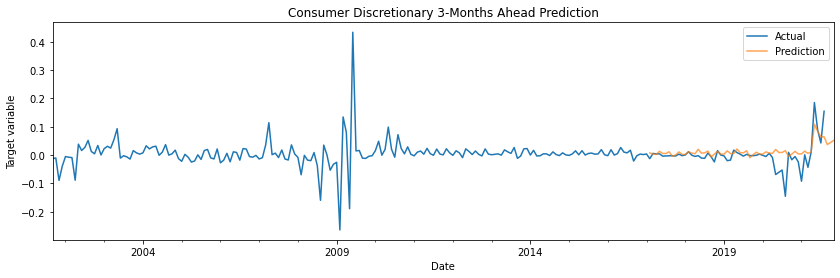

MAPE: 3.131
MAE: 0.02


In [364]:
sar3_pred_mean = sar3_pred.predicted_mean
sar3_pred_ci = sar3_pred.conf_int()
ax = df_3.target.plot(label='Actual')
sar3_pred_mean.plot(ax=ax, label='Prediction', alpha=.7, figsize=(14, 4))
ax.set_xlabel('Date')
ax.set_ylabel('Target variable')
plt.title('Consumer Discretionary 3-Months Ahead Prediction')
plt.legend()
plt.show()

last_date = y_test.dropna().index[-1]

print("MAPE:", round(mape(y_test[y_test.index < last_date], sar3_pred_mean[sar3_pred_mean.index < last_date]), 3))
print("MAE:", round(mae(y_test[y_test.index < last_date], sar3_pred_mean[sar3_pred_mean.index < last_date]), 3))

## SARIMAX Model - 6 month

In [365]:
var_corr_6 = (df_6.corr().sort_values('target'))
var_corr_6.head()

,target,emp_mom_ch,emp_yoy_ch,emp,pce_mom_ch,pce_yoy_ch,pce,cpi_mom_ch,cpi_yoy_ch,cpi,...,usdcny_5,usdcny_6,usdcny_7,usdcny_8,usdcny_9,usdcny_10,usdcny_11,usdcny_12,usdcny_13,month
emp_yoy_ch_7,-0.337812,-0.004369,0.372301,0.216030,-0.134801,0.051017,-0.048270,-0.107318,0.050741,-0.038594,...,-0.033255,-0.043652,-0.052294,-0.058639,-0.063282,-0.065615,-0.070248,-0.074593,-0.079710,-0.009245
cpi_mom_ch_1,-0.330415,0.114464,0.185980,0.038701,0.376218,0.332634,-0.012037,0.471791,0.409720,0.003330,...,0.114061,0.116047,0.120152,0.126049,0.132857,0.136900,0.136220,0.134347,0.132723,-0.045036
emp_yoy_ch_6,-0.295723,-0.010420,0.418141,0.199634,-0.094640,0.070780,-0.063767,-0.093339,0.076567,-0.052412,...,-0.038419,-0.046144,-0.052399,-0.057872,-0.060955,-0.067132,-0.072498,-0.079053,-0.084513,0.009407
emp_yoy_ch_8,-0.254766,-0.004465,0.320722,0.232849,-0.187102,0.025031,-0.033253,-0.124231,0.018234,-0.025039,...,-0.026839,-0.038651,-0.050049,-0.058821,-0.064311,-0.068189,-0.068861,-0.072419,-0.075234,-0.027330
soc_7,-0.250923,0.029844,0.200487,0.444935,0.058905,0.282785,0.046468,0.083383,0.199211,-0.009357,...,0.339666,0.326118,0.312884,0.299876,0.286730,0.273380,0.259747,0.244498,0.228227,-0.079886


In [74]:
var_corr_6.tail()

,target,emp_mom_ch,emp_yoy_ch,emp,pce_mom_ch,pce_yoy_ch,pce,cpi_mom_ch,cpi_yoy_ch,cpi,...,usdcny_5,usdcny_6,usdcny_7,usdcny_8,usdcny_9,usdcny_10,usdcny_11,usdcny_12,usdcny_13,month
unemp_6,0.242951,0.053183,-0.130230,-0.509520,-0.081500,-0.326551,-0.065419,-0.004422,-0.147353,-0.018635,...,-0.298810,-0.292564,-0.288564,-0.284936,-0.282536,-0.276513,-0.269339,-0.259314,-0.250147,-0.016980
unemp_yoy_ch_7,0.256496,-0.068853,-0.586407,-0.486387,-0.074401,-0.286069,-0.341501,-0.003518,-0.156205,-0.346789,...,0.272173,0.275702,0.276244,0.275719,0.275989,0.275712,0.277604,0.283766,0.289949,-0.011699
unemp_7,0.257526,0.051020,-0.056448,-0.510609,-0.049151,-0.297437,-0.079945,0.001700,-0.119642,-0.030204,...,-0.313379,-0.305395,-0.300085,-0.296237,-0.292051,-0.288841,-0.282350,-0.273961,-0.265041,-0.002742
unemp_mom_ch_7,0.270690,0.055063,-0.301176,-0.060634,-0.105673,-0.159747,0.003793,0.005796,-0.125946,-0.002413,...,0.061181,0.062246,0.059774,0.058846,0.058672,0.054760,0.060178,0.063576,0.070240,-0.016264
target,1.000000,-0.007594,-0.099518,-0.156982,-0.139707,-0.147019,-0.085058,-0.085334,-0.198341,-0.091047,...,-0.004051,-0.002945,0.000997,-0.002737,-0.002515,-0.001326,0.001082,0.004997,0.004765,0.014756


In [366]:
model_exvar = ['emp_yoy_ch_7']

# train test split
split_date = pd.Timestamp('2017-01-01')

train = df_6.loc[:split_date]
y_train = train['target']
x_train = train[model_exvar]

test =  df_6.loc[(split_date + relativedelta(months = 1)):]
y_test = test['target']
x_test = test[model_exvar]

#results = pm.auto_arima(y_train, seasonal = True, m = 12, D = 1, information_criterion = 'aic')
#print(results.summary())

sar6_model = SARIMAX(y_train, 
                order = (3,0,0), 
                seasonal_order = (2,1,0,12)
                , exog = x_train
                )

sar6_mod_fit = sar6_model.fit()

sar6_pred = sar6_mod_fit.get_prediction(start = y_test.index[0], end = y_test.index[-1], exog = x_test
                                         )

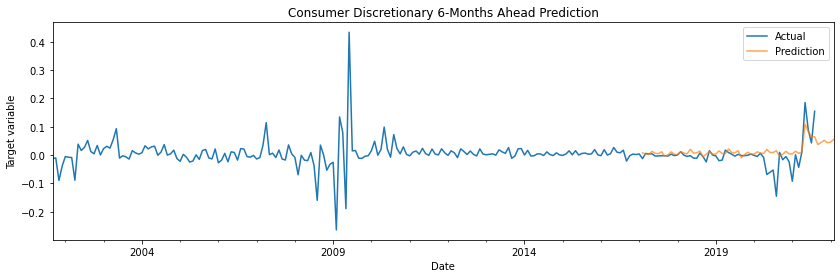

MAPE: 3.131
MAE: 0.02


In [367]:
sar6_pred_mean = sar6_pred.predicted_mean
sar6_pred_ci = sar6_pred.conf_int()
ax = df_6.target.plot(label='Actual')
sar6_pred_mean.plot(ax=ax, label='Prediction', alpha=.7, figsize=(14, 4))
ax.set_xlabel('Date')
ax.set_ylabel('Target variable')
plt.title('Consumer Discretionary 6-Months Ahead Prediction')
plt.legend()
plt.show()

last_date = y_test.dropna().index[-1]

print("MAPE:", round(mape(y_test[y_test.index < last_date], sar6_pred_mean[sar6_pred_mean.index < last_date]), 3))
print("MAE:", round(mae(y_test[y_test.index < last_date], sar6_pred_mean[sar6_pred_mean.index < last_date]), 3))

## SARIMAX Model - 12 month

In [128]:
var_corr_12 = (df_12.corr().sort_values('target'))
var_corr_12.head()

,target,emp_mom_ch,emp_yoy_ch,emp,pce_mom_ch,pce_yoy_ch,pce,cpi_mom_ch,cpi_yoy_ch,cpi,...,usdcny_5,usdcny_6,usdcny_7,usdcny_8,usdcny_9,usdcny_10,usdcny_11,usdcny_12,usdcny_13,month
emp_yoy_ch_1,-0.300006,-0.088900,0.879942,0.375764,-0.037343,0.442433,0.132628,0.010486,0.328400,0.145494,...,-0.125356,-0.127957,-0.134971,-0.140293,-0.142630,-0.136906,-0.133733,-0.132128,-0.130649,0.014620
emp_yoy_ch,-0.261648,0.391994,1.000000,0.377901,0.166641,0.473606,0.097969,0.118876,0.349266,0.112075,...,-0.120089,-0.125198,-0.132247,-0.134553,-0.130436,-0.127608,-0.124926,-0.119646,-0.119951,0.034408
emp_mom_ch_1,-0.235811,0.003755,0.401703,0.100476,0.043942,0.151946,-0.031733,0.115919,0.117461,-0.023825,...,-0.018278,-0.019881,-0.024991,-0.025916,-0.020254,-0.007288,-0.012756,-0.012855,-0.003870,0.030137
soc_1,-0.228104,0.011167,0.379612,0.532068,0.057784,0.258112,0.183073,0.080542,-0.009888,0.113120,...,0.200628,0.184503,0.166741,0.149414,0.133611,0.119633,0.103915,0.087819,0.071222,-0.102457
rrfs_yoy_ch_1,-0.222183,0.162696,0.723793,0.110525,0.126057,0.379945,-0.008252,0.194155,0.345084,-0.008247,...,0.016166,0.010461,0.003472,-0.002938,-0.005566,-0.007214,-0.015565,-0.024353,-0.031085,0.019935


In [82]:
var_corr_12.tail()

,target,emp_mom_ch,emp_yoy_ch,emp,pce_mom_ch,pce_yoy_ch,pce,cpi_mom_ch,cpi_yoy_ch,cpi,...,usdcny_5,usdcny_6,usdcny_7,usdcny_8,usdcny_9,usdcny_10,usdcny_11,usdcny_12,usdcny_13,month
unemp,0.247768,-0.245119,-0.620980,-0.656582,-0.169676,-0.522410,-0.103441,-0.096650,-0.284401,-0.061233,...,-0.248597,-0.238372,-0.229034,-0.221815,-0.220407,-0.216831,-0.212362,-0.208197,-0.202993,-0.024412
unemp_yoy_ch_1,0.256875,-0.059503,-0.847908,-0.430439,-0.043028,-0.352795,-0.323959,-0.046002,-0.220803,-0.329388,...,0.263431,0.269872,0.276326,0.282332,0.284777,0.284005,0.286432,0.292425,0.296799,-0.009473
unemp_1,0.263166,0.120350,-0.478553,-0.637425,-0.019387,-0.483718,-0.120357,-0.015279,-0.257930,-0.075487,...,-0.260273,-0.251746,-0.242666,-0.233244,-0.226933,-0.225672,-0.221276,-0.214152,-0.210133,-0.010004
unemp_mom_ch_1,0.274116,-0.189276,-0.550955,-0.129454,-0.123779,-0.177528,0.013061,-0.120861,-0.112626,0.004769,...,0.053351,0.056895,0.063798,0.065442,0.060856,0.051165,0.058703,0.057269,0.054048,-0.016116
target,1.000000,0.034265,-0.256635,-0.202498,0.034646,-0.142002,-0.086041,0.134924,-0.056939,-0.078224,...,-0.000519,0.003576,0.003343,0.007533,0.007547,0.007475,0.010981,0.015511,0.016815,0.006950


In [531]:
model_exvar = ['emp_yoy_ch_1']

# train test split
split_date = pd.Timestamp('2017-01-01')

train = df_12.loc[:split_date]
y_train = train['target']
x_train = train[model_exvar]

test =  df_12.loc[(split_date + relativedelta(months = 1)):]
y_test = test['target']
x_test = test[model_exvar]

#results = pm.auto_arima(y_train, seasonal = True, m = 12, D = 1, information_criterion = 'aic')
#print(results.summary())

sar12_model = SARIMAX(y_train, 
                order = (3,0,0), 
                seasonal_order = (2,1,0,12)
                , exog = x_train
                )

sar12_mod_fit = sar12_model.fit()

sar12_pred = sar12_mod_fit.get_prediction(start = y_test.index[0], end = y_test.index[-1], exog = x_test
                                         )

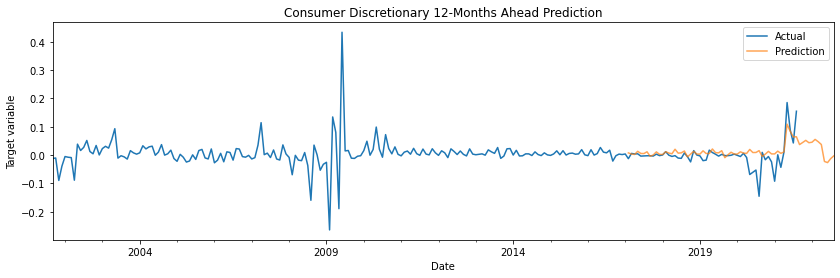

MAPE: 3.131
MAE: 0.02


In [532]:
sar12_pred_mean = sar12_pred.predicted_mean
sar12_pred_ci = sar12_pred.conf_int()
ax = df_12.target.plot(label='Actual')
sar12_pred_mean.plot(ax=ax, label='Prediction', alpha=.7, figsize=(14, 4))
ax.set_xlabel('Date')
ax.set_ylabel('Target variable')
plt.title('Consumer Discretionary 12-Months Ahead Prediction')
plt.legend()
plt.show()

last_date = y_test.dropna().index[-1]

print("MAPE:", round(mape(y_test[y_test.index < last_date], sar12_pred_mean[sar12_pred_mean.index < last_date]), 3))
print("MAE:", round(mae(y_test[y_test.index < last_date], sar12_pred_mean[sar12_pred_mean.index < last_date]), 3))

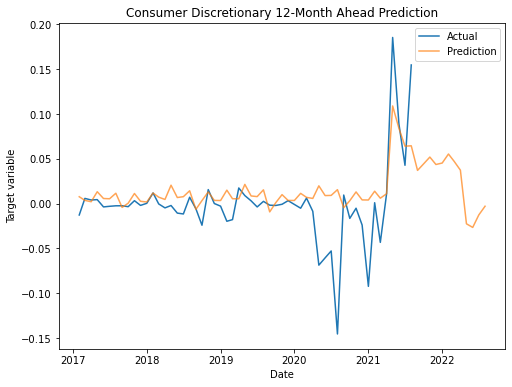

In [534]:
first_date = y_test.index[0]
last_date = y_test.dropna().index[-1]


fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(df_12[df_12.index >= first_date].index, df_12[df_12.index >= first_date].target, label = 'Actual')
ax.plot(sar12_pred_mean.index, sar12_pred_mean, label='Prediction', alpha=.7)
ax.set_xlabel('Date')
ax.set_ylabel('Target variable')
plt.title('Consumer Discretionary 12-Month Ahead Prediction')
plt.legend()
plt.show()

## SARIMAX Model - 18 month

In [133]:
var_corr_18 = (df_18.corr().sort_values('target'))
var_corr_18.head()

,target,emp_mom_ch,emp_yoy_ch,emp,pce_mom_ch,pce_yoy_ch,pce,cpi_mom_ch,cpi_yoy_ch,cpi,...,usdcny_4,usdcny_5,usdcny_6,usdcny_7,usdcny_8,usdcny_9,usdcny_10,usdcny_11,usdcny_12,usdcny_13
soc_1,-0.187316,0.487304,0.483025,0.526163,0.106613,0.250925,0.189841,0.107259,-0.020663,0.114653,...,0.217171,0.201928,0.186001,0.170550,0.155014,0.139628,0.125472,0.109677,0.092804,0.074377
soc,-0.170228,0.490027,0.470474,0.523731,0.149276,0.231565,0.203393,0.048264,-0.064092,0.126724,...,0.198158,0.181804,0.164895,0.149481,0.133715,0.118489,0.102639,0.085937,0.067862,0.049513
soc_yoy_ch_1,-0.168176,0.463296,0.156432,0.036737,-0.028683,-0.181766,0.205419,0.049421,-0.383879,0.182951,...,-0.205332,-0.215416,-0.227579,-0.239824,-0.251956,-0.262850,-0.272651,-0.283180,-0.293381,-0.303868
soc_mom_ch_10,-0.164422,0.141821,0.090308,0.034576,-0.044994,0.015984,0.061292,-0.000691,-0.036954,0.059421,...,-0.043349,-0.044424,-0.048899,-0.049527,-0.053376,-0.057159,-0.060094,-0.063037,-0.066118,-0.068071
soc_yoy_ch,-0.162960,0.407226,0.095122,0.023945,0.042307,-0.194533,0.202186,-0.022051,-0.448544,0.177521,...,-0.208922,-0.221444,-0.234541,-0.246752,-0.257950,-0.268326,-0.278993,-0.289246,-0.299702,-0.308859


In [88]:
var_corr_18.tail()

,target,emp_mom_ch,emp_yoy_ch,emp,pce_mom_ch,pce_yoy_ch,pce,cpi_mom_ch,cpi_yoy_ch,cpi,...,usdcny_4,usdcny_5,usdcny_6,usdcny_7,usdcny_8,usdcny_9,usdcny_10,usdcny_11,usdcny_12,usdcny_13
unemp_mom_ch_3,0.185183,-0.505444,-0.463901,-0.203666,-0.117062,-0.179294,-0.226561,-0.073880,-0.094734,-0.221266,...,0.140289,0.146645,0.147459,0.143978,0.150214,0.153578,0.159411,0.165703,0.169613,0.180186
vix_1,0.202626,-0.737089,-0.661852,-0.388018,-0.195924,-0.362876,-0.289379,-0.298506,-0.234952,-0.280457,...,0.062300,0.066063,0.069047,0.072281,0.078718,0.088299,0.101506,0.116365,0.131767,0.148183
unemp_mom_ch_11,0.212856,-0.301725,-0.507010,-0.275728,-0.095551,-0.143672,-0.222231,-0.087302,-0.107397,-0.223397,...,0.142832,0.140588,0.143899,0.144487,0.142889,0.140795,0.143209,0.144984,0.152266,0.156438
unemp_mom_ch,0.238413,-0.419278,-0.355954,-0.125085,-0.027337,-0.086658,-0.178608,-0.076038,-0.019835,-0.171256,...,0.114960,0.121247,0.124056,0.130141,0.136903,0.141476,0.153229,0.164192,0.177252,0.183187
target,1.000000,-0.106383,-0.109587,-0.102893,0.005252,-0.057025,-0.070881,-0.081398,0.051875,-0.059266,...,-0.003414,0.000294,0.005053,0.006486,0.012094,0.015458,0.019648,0.024344,0.028946,0.031234


In [523]:
#model_exvar = ['soc_1', 'unemp_mom_ch']

# train test split
split_date = pd.Timestamp('2017-01-01')

train = df_18.loc[:split_date]
y_train = train['target']
x_train = train[model_exvar]

test =  df_18.loc[(split_date + relativedelta(months = 1)):]
y_test = test['target']
x_test = test[model_exvar]

#results = pm.auto_arima(y_train, seasonal = True, m = 12, D = 1, information_criterion = 'aic')
#print(results.summary())

sar18_model = SARIMAX(y_train, 
                order = (3,0,0), 
                seasonal_order = (2,1,0,12)
                #, exog = x_train
                )

sar18_mod_fit = sar18_model.fit()

sar18_pred = sar18_mod_fit.get_prediction(start = y_test.index[0], end = y_test.index[-1], # exog = x_test
                                         )

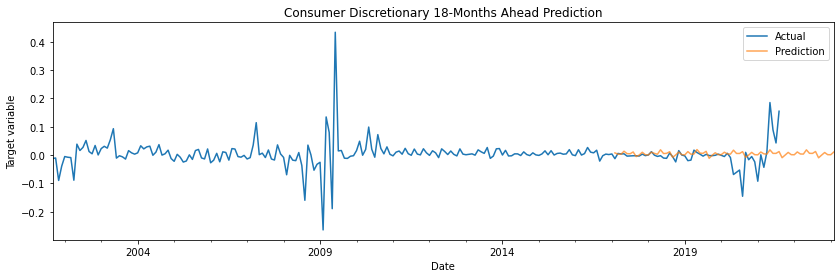

MAPE: 2.541
MAE: 0.023


In [524]:
sar18_pred_mean = sar18_pred.predicted_mean
sar18_pred_ci = sar18_pred.conf_int()
ax = df_18.target.plot(label='Actual')
sar18_pred_mean.plot(ax=ax, label='Prediction', alpha=.7, figsize=(14, 4))
ax.set_xlabel('Date')
ax.set_ylabel('Target variable')
plt.title('Consumer Discretionary 18-Months Ahead Prediction')
plt.legend()
plt.show()

last_date = y_test.dropna().index[-1]

print("MAPE:", round(mape(y_test[y_test.index < last_date], sar18_pred_mean[sar18_pred_mean.index < last_date]), 3))
print("MAE:", round(mae(y_test[y_test.index < last_date], sar18_pred_mean[sar18_pred_mean.index < last_date]), 3))

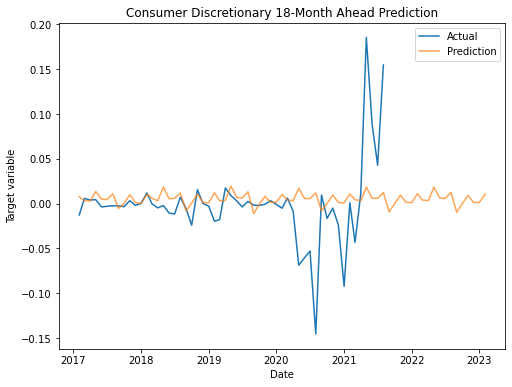

In [530]:
first_date = y_test.index[0]
last_date = y_test.dropna().index[-1]


fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(df_18[df_18.index >= first_date].index, df_18[df_18.index >= first_date].target, label = 'Actual')
ax.plot(sar18_pred_mean.index, sar18_pred_mean, label='Prediction', alpha=.7)
ax.set_xlabel('Date')
ax.set_ylabel('Target variable')
plt.title('Consumer Discretionary 18-Month Ahead Prediction')
plt.legend()
plt.show()

## Future Forecast

In [393]:
pred18 = pd.DataFrame(sar18_pred_mean).rename(columns = {'predicted_mean' : 'pred18'})
pred18.index = pred18.index.rename('date')
pred12 = pd.DataFrame(sar12_pred_mean).rename(columns = {'predicted_mean' : 'pred12'})
pred12.index = pred12.index.rename('date')
pred1 = pd.DataFrame(sar1_pred_mean).rename(columns = {'predicted_mean' : 'pred1'})
pred1.index = pred1.index.rename('date')

In [400]:
pred_joined = pred18.join(pred12).join(pred1)
pred_joined

,pred18,pred12,pred1
date,,,
2017-02-01,0.007796,0.007768,0.005810
2017-03-01,0.003264,0.003682,0.005059
2017-04-01,0.003045,0.002199,0.001786
2017-05-01,0.013614,0.013350,0.014184
2017-06-01,0.005128,0.005784,0.008196
...,...,...,...
2022-10-01,-0.000017,NaN,NaN
2022-11-01,0.009127,NaN,NaN
2022-12-01,0.001488,NaN,NaN


In [403]:
pred_joined['combined_pred'] = pred_joined.pred1.fillna(pred_joined.pred12).fillna(pred_joined.pred18)
pred_joined

,pred18,pred12,pred1,combined_pred
date,,,,
2017-02-01,0.007796,0.007768,0.005810,0.005810
2017-03-01,0.003264,0.003682,0.005059,0.005059
2017-04-01,0.003045,0.002199,0.001786,0.001786
2017-05-01,0.013614,0.013350,0.014184,0.014184
2017-06-01,0.005128,0.005784,0.008196,0.008196
...,...,...,...,...
2022-10-01,-0.000017,NaN,NaN,-0.000017
2022-11-01,0.009127,NaN,NaN,0.009127
2022-12-01,0.001488,NaN,NaN,0.001488


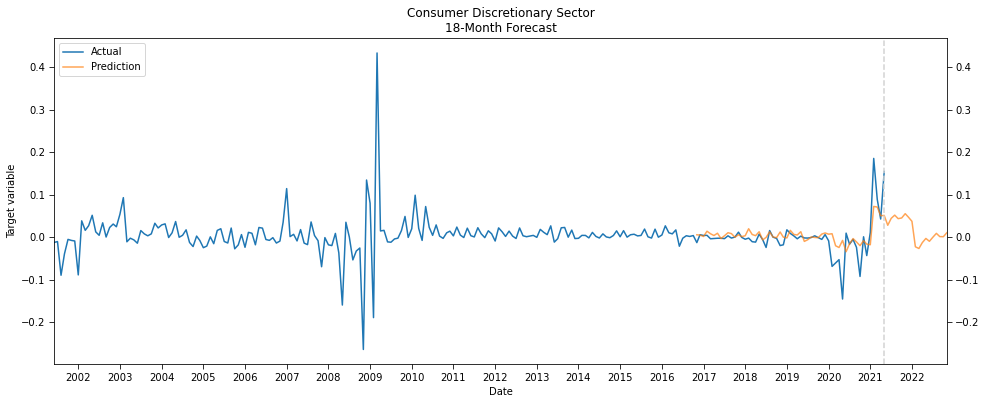

In [507]:
# from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

# plot inputs
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(df_18.index, df_18.target, label = 'Actual')
ax.plot(pred_joined.index, pred_joined.combined_pred, label='Prediction', alpha=.7)
ax.axvline(df_18.dropna().index[-1], c = 'lightgrey', linestyle = '--')

# format the axes
ax.xaxis.set_major_formatter(DateFormatter("%Y")) 
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 12))

ax.yaxis.set_ticks_position('both')
ax.tick_params(length = 5, axis = 'both', labelright = True, direction = 'out')

ax.margins(x=0) # remove whitespace

# labels
ax.set(xlabel = 'Date', ylabel = 'Target variable', 
       title = 'Consumer Discretionary Sector\n18-Month Forecast')

plt.legend()
plt.show()

## Using Wonsuk's plot code

In [241]:
pred_results1 = pd.DataFrame(df_1.target).join(sar1_pred_mean).join(sar1_pred_ci)
pred_results1

,target,predicted_mean,lower target,upper target
date,,,,
2001-10-01,-0.010199,NaN,NaN,NaN
2001-11-01,-0.089454,NaN,NaN,NaN
2001-12-01,-0.039080,NaN,NaN,NaN
2002-01-01,-0.005086,NaN,NaN,NaN
2002-02-01,-0.007537,NaN,NaN,NaN
...,...,...,...,...
2021-04-01,0.011165,-0.017909,-0.070282,0.034464
2021-05-01,0.185528,0.068801,0.016318,0.121284
2021-06-01,0.089035,0.067787,0.014981,0.120593


* Index converted to datetime. Please verify example below.
from 2001-10-01 00:00:00 to 2001-10-01 00:00:00

* Dropping duplicate index values. Keeping last.

* Oops. Something went wrong ---> None
* Oops. Something went wrong ---> None


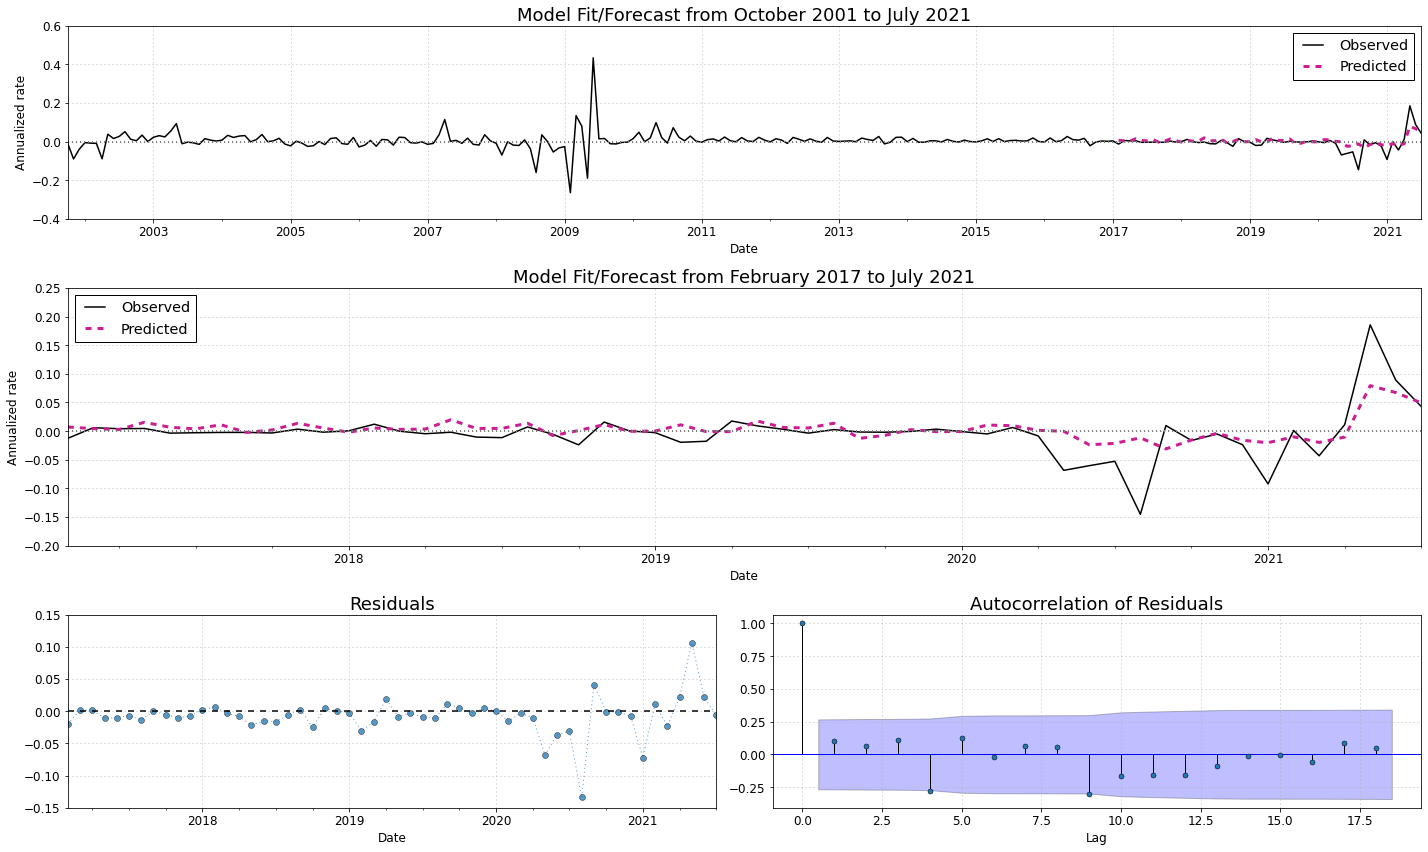

In [156]:
f = plot_forecast(data=pred_results1, data_index_col=0, # <-- col to set as index / can also be 'ds' or wtvr
                  y='target', yhat='predicted_mean', ci_lower=None, ci_upper=None,
                  start_date = '2017-02-01',
                  print_mse=False)

In [121]:
pred_results3 = pd.DataFrame(df_3.target).join(sar3_pred_mean).join(sar3_pred_ci)
pred_results3

,target,predicted_mean,lower target,upper target
date,,,,
2001-12-01,-0.039080,NaN,NaN,NaN
2002-01-01,-0.005086,NaN,NaN,NaN
2002-02-01,-0.007537,NaN,NaN,NaN
2002-03-01,-0.008820,NaN,NaN,NaN
2002-04-01,-0.088647,NaN,NaN,NaN
...,...,...,...,...
2021-03-01,-0.043162,0.006029,-0.145951,0.158008
2021-04-01,0.011165,0.010527,-0.141464,0.162517
2021-05-01,0.185528,0.102584,-0.050032,0.255199


* Index converted to datetime. Please verify example below.
from 2001-12-01 00:00:00 to 2001-12-01 00:00:00

* Dropping duplicate index values. Keeping last.

* Oops. Something went wrong ---> None
* Oops. Something went wrong ---> None


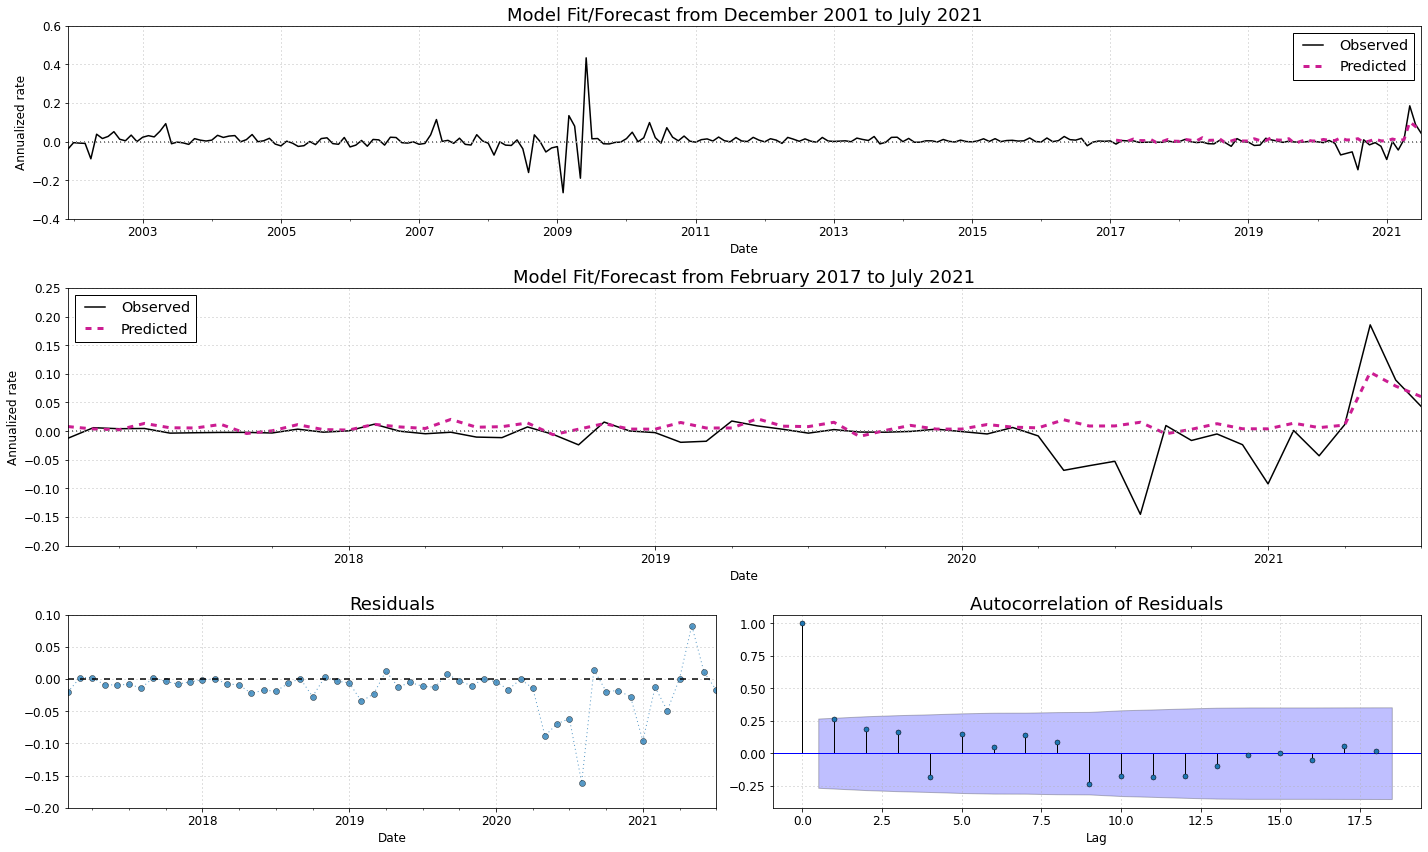

In [122]:
f = plot_forecast(data=pred_results3, # <-- col to set as index / can also be 'ds' or wtvr
                  y='target', yhat='predicted_mean', ci_lower=None, ci_upper=None,
                  start_date = '2017-02-01',
                  print_mse=False)

In [126]:
pred_results6 = pd.DataFrame(df_6.target).join(sar6_pred_mean).join(sar6_pred_ci)

pred_results6

,target,predicted_mean,lower target,upper target
date,,,,
2002-03-01,-0.008820,NaN,NaN,NaN
2002-04-01,-0.088647,NaN,NaN,NaN
2002-05-01,0.038620,NaN,NaN,NaN
2002-06-01,0.016250,NaN,NaN,NaN
2002-07-01,0.027191,NaN,NaN,NaN
...,...,...,...,...
2021-03-01,-0.043162,0.005996,-0.147328,0.159320
2021-04-01,0.011165,0.010456,-0.142876,0.163789
2021-05-01,0.185528,0.101423,-0.052562,0.255409


* Index converted to datetime. Please verify example below.
from 2002-03-01 00:00:00 to 2002-03-01 00:00:00

* Dropping duplicate index values. Keeping last.

* Oops. Something went wrong ---> None
* Oops. Something went wrong ---> None


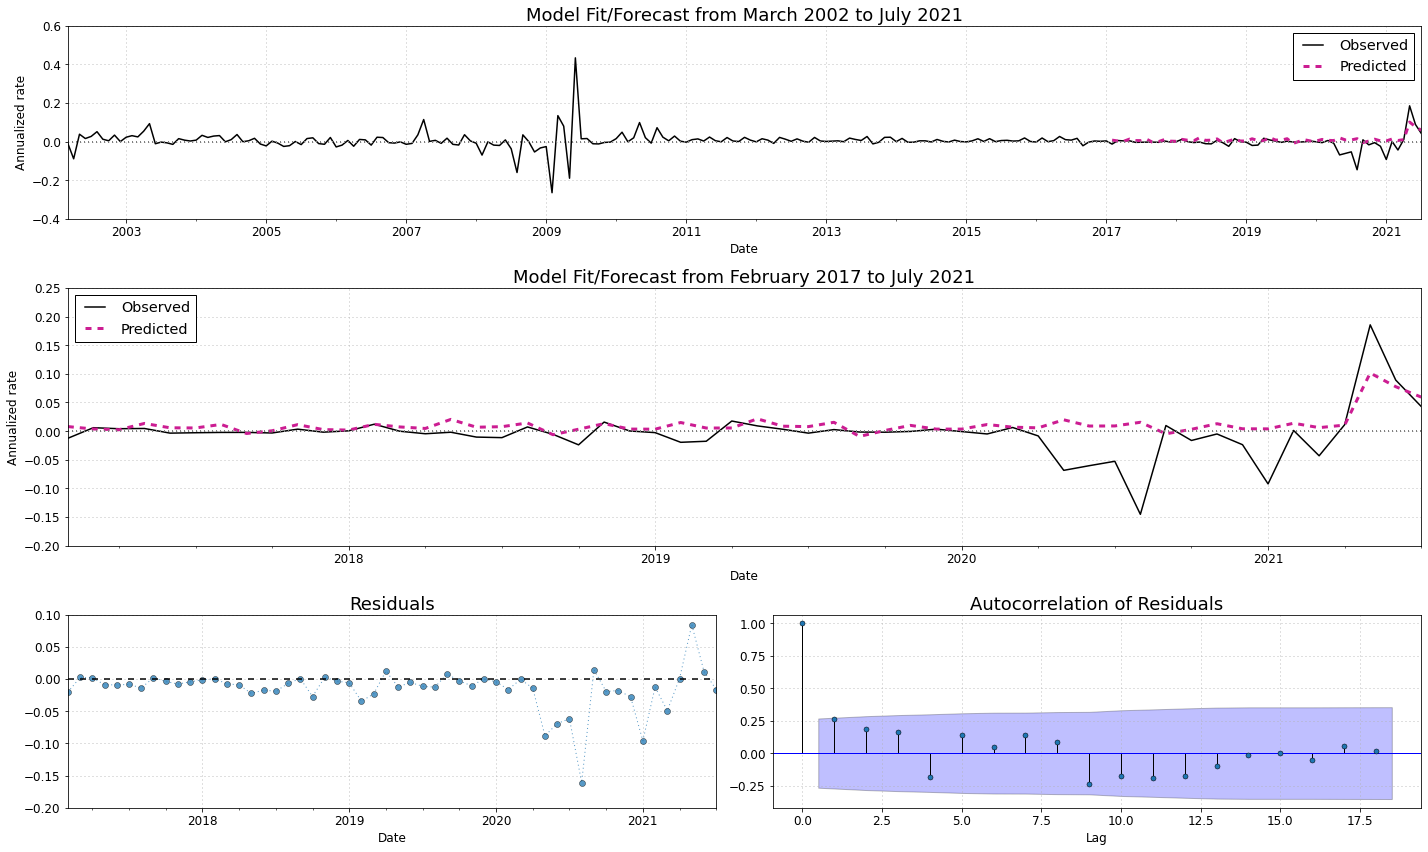

In [127]:
f = plot_forecast(data=pred_results6, # <-- col to set as index / can also be 'ds' or wtvr
                  y='target', yhat='predicted_mean', ci_lower=None, ci_upper=None,
                  start_date = '2017-02-01',
                  print_mse=False)

In [131]:
pred_results12 = pd.DataFrame(df_12.target).join(sar12_pred_mean).join(sar12_pred_ci)
pred_results12

,target,predicted_mean,lower target,upper target
date,,,,
2002-09-01,0.012685,NaN,NaN,NaN
2002-10-01,0.004563,NaN,NaN,NaN
2002-11-01,0.033940,NaN,NaN,NaN
2002-12-01,0.000507,NaN,NaN,NaN
2003-01-01,0.022994,NaN,NaN,NaN
...,...,...,...,...
2021-03-01,-0.043162,0.005957,-0.149714,0.161627
2021-04-01,0.011165,0.010188,-0.145497,0.165873
2021-05-01,0.185528,0.097294,-0.059089,0.253677


* Index converted to datetime. Please verify example below.
from 2002-09-01 00:00:00 to 2002-09-01 00:00:00

* Dropping duplicate index values. Keeping last.

* Oops. Something went wrong ---> None
* Oops. Something went wrong ---> None


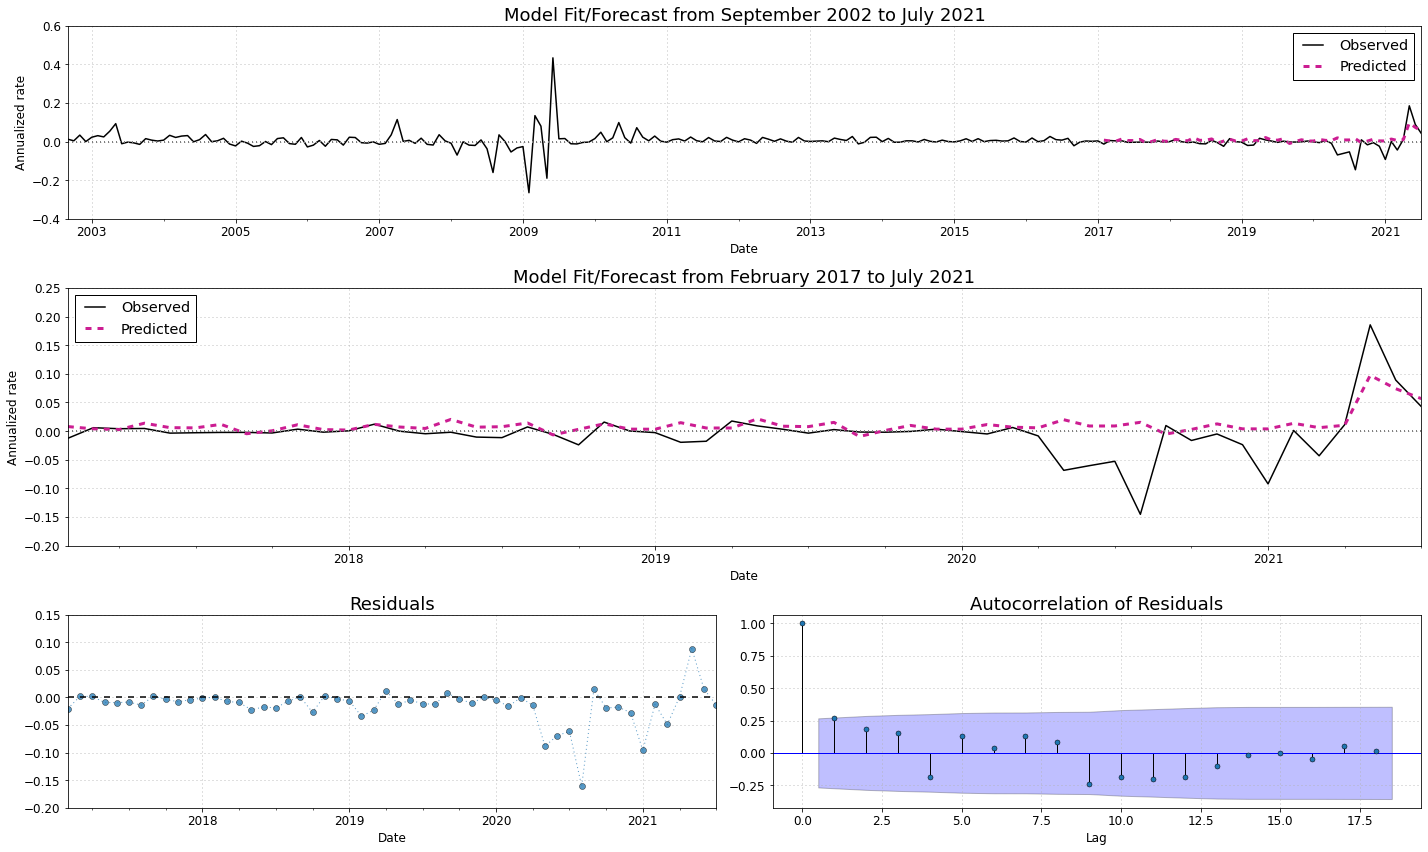

In [132]:
f = plot_forecast(data=pred_results12, # <-- col to set as index / can also be 'ds' or wtvr
                  y='target', yhat='predicted_mean', ci_lower=None, ci_upper=None,
                  start_date = '2017-02-01',
                  print_mse=False)

In [136]:
pred_results18 = pd.DataFrame(df_18.target).join(sar18_pred_mean).join(sar18_pred_ci)
pred_results18

,target,predicted_mean,lower target,upper target
date,,,,
2003-03-01,0.024657,NaN,NaN,NaN
2003-04-01,0.054098,NaN,NaN,NaN
2003-05-01,0.093212,NaN,NaN,NaN
2003-06-01,-0.010682,NaN,NaN,NaN
2003-07-01,-0.002269,NaN,NaN,NaN
...,...,...,...,...
2021-03-01,-0.043162,0.004443,-0.157262,0.166148
2021-04-01,0.011165,0.003553,-0.158190,0.165295
2021-05-01,0.185528,0.018654,-0.143909,0.181218


* Index converted to datetime. Please verify example below.
from 2003-03-01 00:00:00 to 2003-03-01 00:00:00

* Dropping duplicate index values. Keeping last.

* Oops. Something went wrong ---> None
* Oops. Something went wrong ---> None


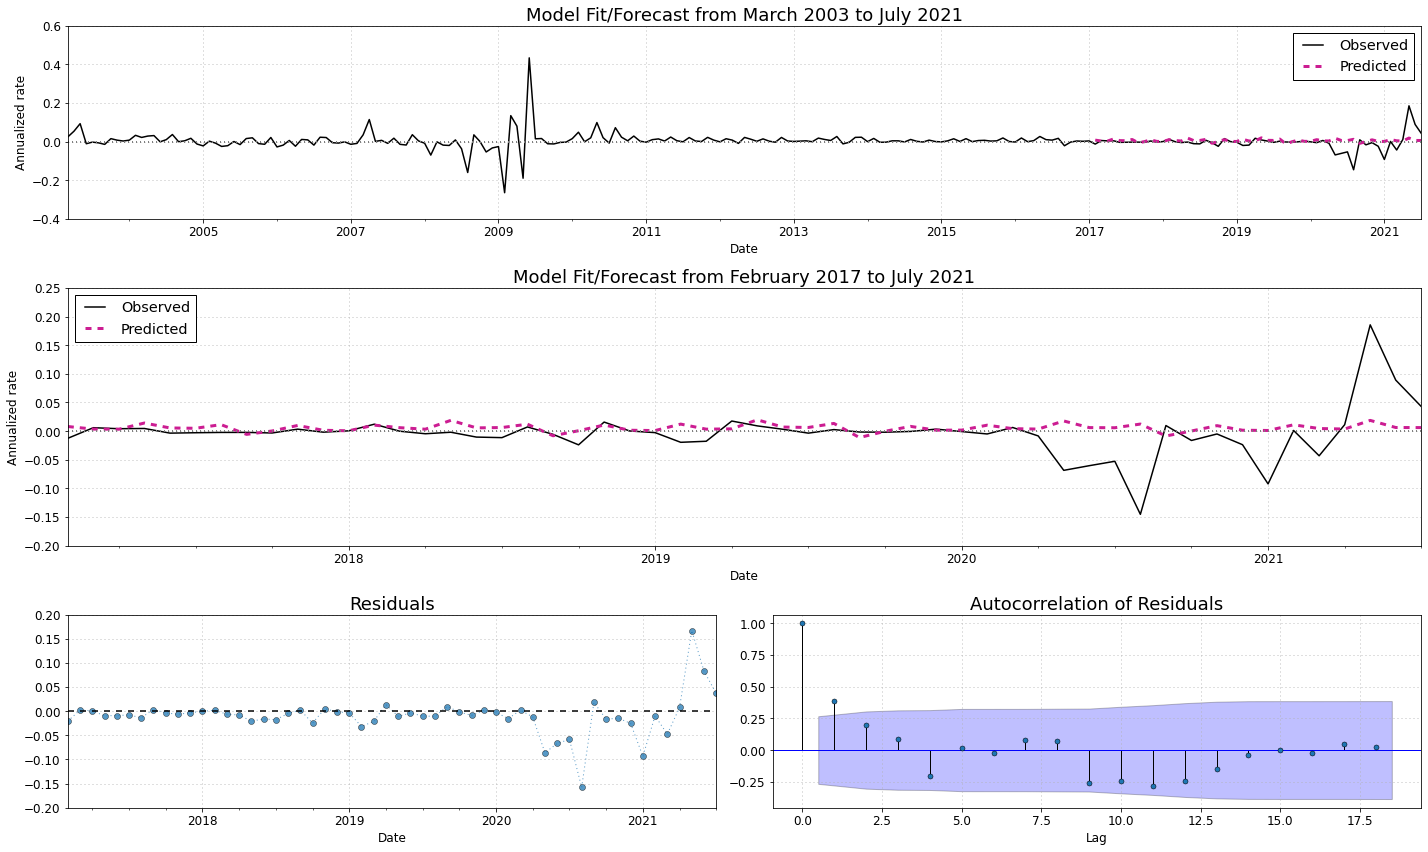

In [137]:
f = plot_forecast(data=pred_results18, # <-- col to set as index / can also be 'ds' or wtvr
                  y='target', yhat='predicted_mean', ci_lower=None, ci_upper=None,
                  start_date = '2017-02-01',
                  print_mse=False)

## XGBoost

In [ ]:
import xgboost as xgb

In [ ]:
# look at seasonality
decomp_results = seasonal_decompose(df_1['target'], period = 12)
decomp_results.plot()
plt.show()

In [ ]:
plt.plot(decomp_results.trend)

In [ ]:
# train test split
split_date = pd.Timestamp('2017-01-01')

model_exvar = ['emp_yoy_ch_12', 'month']

train = df_12.loc[:split_date]
x_train = (train[model_exvar])
y_train = train.target

test =  df_12.loc[(split_date + relativedelta(months = 1)):]
x_test = (test[model_exvar])
y_test = test.target

In [ ]:
xgb_reg = xgb.XGBRegressor(objective = 'reg:linear',
                           n_estimators = 100, seed = 123)
xgb_mod = xgb_reg.fit(x_train, y_train)
xgb_preds = xgb_mod.predict(x_test)

In [ ]:
plt.plot(xgb_preds, label= 'Prediction')
plt.plot(np.array(y_test), label = 'Actual')
plt.title('1-Month Prediction')
plt.legend()
plt.show()

print("MAPE:", round(mape(y_test, xgb_preds), 2))
print("MAE:", round(mae(y_test, xgb_preds), 3))

## Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
df_18.columns

In [ ]:
model_exvar = ['emp_mom_ch', 'emp_yoy_ch', 'emp', 
               'pce_mom_ch', 'pce_yoy_ch', 'pce', 'cpi_mom_ch', 'cpi_yoy_ch', 'cpi',
               'unemp_mom_ch', 'unemp_yoy_ch', 'unemp',
               'rrfs_mom_ch', 'rrfs_yoy_ch', 'rrfs',
               'rsxfs_mom_ch', 'rsxfs_yoy_ch', 'rsxfs', 
               'soc_mom_ch', 'soc_yoy_ch', 'soc', 
               'vix_mom_ch', 'vix_yoy_ch', 'vix', 'month'
              ]

In [ ]:
var_corr = (df_18.corr().sort_values('target'))

In [ ]:
var_corr

In [ ]:
ex_18 = ['soc_1', 
         'soc', 
         'soc_yoy_ch_1', 
         'soc_mom_ch_4', 
         'soc_yoy_ch',
         'unemp_yoy_ch',
         'unemp_mom_ch_3',
         'vix_1',
         'unemp_mom_ch',
         'month'
        ]

### 18 Month

In [ ]:
# train test split
split_date = pd.Timestamp('2017-01-01')

train = df_18.loc[:split_date]
y_train = np.array(train['target'])
x_train = np.array(train[model_exvar])

test =  df_18.loc[(split_date + relativedelta(months = 1)):]
y_test = np.array(test['target'])
x_test = test[model_exvar]

rf_reg = RandomForestRegressor(max_depth=2, random_state=42)
rf_reg.fit(x_train, y_train)
rf_reg_pred = rf_reg.predict(x_test)

plt.plot(rf_reg_pred, label= 'Prediction')
plt.plot(y_test, label = 'Actual')
plt.title('18-Month Prediction')
plt.legend()
plt.show()

print("MAPE:", round(mape(y_test, rf_reg_pred), 2))
print("MAE:", round(mae(y_test, rf_reg_pred), 3))

In [ ]:
# emsemble
pred_com = 0.5*sar_pred + 0.5*rf_reg_pred
plt.plot(test['target'], label = 'Actual')
plt.plot(pred_com, label = 'Prediction')
plt.title('Ensembled 18-Month Ahead Prediction')
plt.legend()
plt.show()

print("MAPE:", round(mape(y_test, pred_com), 3))
print("MAE:", round(mae(y_test, pred_com), 3))

### 3 Month

In [ ]:
# train test split
split_date = pd.Timestamp('2017-01-01')

train = df_3.loc[:split_date]
y_train = np.array(train['target'])
x_train = np.array(train[model_exvar])

test =  df_3.loc[(split_date + relativedelta(months = 1)):]
y_test = np.array(test['target'])
x_test = test[model_exvar]

rf_reg = RandomForestRegressor(max_depth=2, random_state=42)
rf_reg.fit(x_train, y_train)
rf_reg_pred = rf_reg.predict(x_test)

plt.plot(rf_reg_pred, label= 'Prediction')
plt.plot(y_test, label = 'Actual')
plt.title('3-Month Prediction')
plt.legend()
plt.show()

print("MAPE:", round(mape(y_test, rf_reg_pred), 2))
print("MAE:", round(mae(y_test, rf_reg_pred), 3))

### 6 Month

In [ ]:
# train test split
split_date = pd.Timestamp('2017-01-01')

train = df_6.loc[:split_date]
y_train = np.array(train['target'])
x_train = np.array(train[model_exvar])

test =  df_6.loc[(split_date + relativedelta(months = 1)):]
y_test = np.array(test['target'])
x_test = test[model_exvar]

rf_reg = RandomForestRegressor(max_depth=2, random_state=42)
rf_reg.fit(x_train, y_train)
rf_reg_pred = rf_reg.predict(x_test)

plt.plot(rf_reg_pred, label= 'Prediction')
plt.plot(y_test, label = 'Actual')
plt.title('6-Month Prediction')
plt.legend()
plt.show()

print("MAPE:", round(mape(y_test, rf_reg_pred), 2))
print("MAE:", round(mae(y_test, rf_reg_pred), 3))

In [ ]:
# emsemble
pred_com = 0.7*sar_pred + 0.3*rf_reg_pred
plt.plot(test['target'], label = 'Actual')
plt.plot(pred_com, label = 'Prediction')
plt.title('Ensembled 6-Month Prediction')
plt.legend()
plt.show()

print("MAPE:", round(mape(y_test, pred_com), 3))
print("MAE:", round(mae(y_test, pred_com), 3))

### 12 Month

In [ ]:
# train test split
split_date = pd.Timestamp('2017-01-01')

train = df_12.loc[:split_date]
y_train = np.array(train['target'])
x_train = np.array(train[model_exvar])

test =  df_12.loc[(split_date + relativedelta(months = 1)):]
y_test = np.array(test['target'])
x_test = test[model_exvar]

rf_reg = RandomForestRegressor(max_depth=2, random_state=42)
rf_reg.fit(x_train, y_train)
rf_reg_pred = rf_reg.predict(x_test)

plt.plot(rf_reg_pred, label= 'Prediction')
plt.plot(y_test, label = 'Actual')
plt.title('12-Month Prediction')
plt.legend()
plt.show()

print("MAPE:", round(mape(y_test, rf_reg_pred), 2))
print("MAE:", round(mae(y_test, rf_reg_pred), 3))

In [ ]:
# emsemble
pred_com = 0.7*sar_pred + 0.3*rf_reg_pred
plt.plot(test['target'], label = 'Actual')
plt.plot(pred_com, label = 'Prediction')
plt.title('Ensembled 18-Month Prediction')
plt.legend()
plt.show()

print("MAPE:", round(mape(y_test, pred_com), 3))
print("MAE:", round(mae(y_test, pred_com), 3))

### 1 Month

In [ ]:
# train test split
split_date = pd.Timestamp('2017-01-01')

train = df_1.loc[:split_date]
y_train = np.array(train['target'])
x_train = np.array(train[model_exvar])

test =  df_1.loc[(split_date + relativedelta(months = 1)):]
y_test = np.array(test['target'])
x_test = test[model_exvar]

rf_reg = RandomForestRegressor(max_depth=2, random_state=42)
rf_reg.fit(x_train, y_train)
rf_reg_pred = rf_reg.predict(x_test)

plt.plot(rf_reg_pred, label= 'Prediction')
plt.plot(y_test, label = 'Actual')
plt.title('1-Month Prediction')
plt.legend()
plt.show()

print("MAPE:", round(mape(y_test, rf_reg_pred), 2))
print("MAE:", round(mae(y_test, rf_reg_pred), 3))

In [ ]:
# emsemble
pred_com = 0.5*sar_pred + 0.5*rf_reg_pred
plt.plot(test['target'], label = 'Actual')
plt.plot(pred_com, label = 'Prediction')
plt.title('Ensembled 1-Month Prediction')
plt.legend()
plt.show()

print("MAPE:", round(mape(y_test, pred_com), 3))
print("MAE:", round(mae(y_test, pred_com), 3))

In [ ]:
### 12 Month

# train test split
split_date = pd.Timestamp('2017-01-01')

train = df_12.loc[:split_date]
y_train = np.array(train['target'])
x_train = np.array(train[model_exvar])

test =  df_12.loc[(split_date + relativedelta(months = 1)):]
y_test = np.array(test['target'])
x_test = test[model_exvar]

rf_reg = RandomForestRegressor(max_depth=2, random_state=42)
rf_reg.fit(x_train, y_train)
rf_reg_pred = rf_reg.predict(x_test)

plt.plot(rf_reg_pred, label= 'Prediction')
plt.plot(y_test, label = 'Actual')
plt.title('12-Month Prediction')
plt.legend()
plt.show()

print("MAPE:", round(mape(y_test, rf_reg_pred), 2))
print("MAE:", round(mae(y_test, rf_reg_pred), 3))

# emsemble
pred_com = 0.7*sar_pred + 0.3*rf_reg_pred
plt.plot(test['target'], label = 'Actual')
plt.plot(pred_com, label = 'Prediction')
plt.title('Ensembled 18-Month Prediction')
plt.legend()
plt.show()

print("MAPE:", round(mape(y_test, pred_com), 3))
print("MAE:", round(mae(y_test, pred_com), 3))



## Regression Model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error as mape, mean_absolute_error as mae
from sklearn.linear_model import LinearRegression

In [ ]:
df.columns

In [ ]:
# train test split
split_date = pd.Timestamp('2017-01-01')

train = df_1.loc[:split_date]
y_train = np.array(train['target'])
x_train = np.array(train[model_exvar])

test =  df_1.loc[(split_date + relativedelta(months = 1)):]
y_test = np.array(test['target'])
x_test = test[model_exvar]

lreg_model = LinearRegression().fit(x_train, y_train)
lreg_pred = lreg_model.predict(x_test)

plt.plot(y_test, label = "Actual")
plt.plot(lreg_pred, label= 'Prediction')
plt.legend()
plt.show()

print("MAPE:", round(mape(y_test, lreg_pred), 2))
print("MAE:", round(mae(y_test, lreg_pred), 3))

## Kushal's code

In [ ]:
import numpy as np
import pandas as pd
import datetime
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing

from statsmodels.tsa.seasonal import seasonal_decompose

from sktime.transformations.series.detrend import Deseasonalizer
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.compose import ReducedForecaster
from sktime.forecasting.model_selection import SlidingWindowSplitter
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.forecasting.base import ForecastingHorizon

#from sktime.performance_metrics.forecasting._classes import MetricFunctionWrapper

#from reduce import order

import warnings
warnings.filterwarnings("ignore")  

In [ ]:
# train test split
split_date = pd.Timestamp('2017-01-01')

train = df_1.loc[:split_date]
y_train = pd.to_datetime(pd.Series(train['target']))
x_train = np.array(train[model_exvar])

test =  df_1.loc[(split_date + relativedelta(months = 1)):]
y_test = pd.to_datetime(pd.Series(test['target']))
x_test = test[model_exvar]

y_train.index = pd.DatetimeIndex(y_train.index, freq = 'MS')

In [ ]:
fh = ForecastingHorizon(pd.PeriodIndex(pd.date_range(y_test.index[0], periods=52, freq="MS")), is_relative=False)

In [ ]:
start = y_test.index[0]

end = y_test.index[-1]
end - start

In [ ]:
deseasonalizer  = Deseasonalizer(model="additive", sp=12)
seasonal = deseasonalizer.fit_transform(y_train)

In [ ]:
plt.plot(y_hat)
plt.plot(df_1.target)

In [ ]:
window = 72
steps = 18
split_date = "2018-06-01"

In [ ]:
def target_forecast(val,var):
    reg_model = RandomForestRegressor(n_estimators=2*steps, max_depth=steps, random_state=2)
    pred = order([("1", Deseasonalizer(sp=len(fh), model="additive")),
                  ("2", ReducedForecaster(reg_model, strategy="recursive",window_length=window))])
    return pred

In [ ]:
split = len(df.loc[split_date:])/len(df)
train, test = temporal_train_test_split(df.squeeze(), test_size=split)

def get_gscv(train):
    cv = SlidingWindowSplitter(
        initial_window=int(len(train)),
        start_with_window=True,
    )
    param_grid = {
        "n_estimators": [0.5*steps, steps, 2*steps],
        "max_depth": [0.5*steps, steps, 2*steps],
    }
    gscv = ForecastingGridSearchCV(pred, cv=cv, param_grid=param_grid, scoring=MetricFunctionWrapper(mean_absolute_error))
    return gscv

In [ ]:
forecasts = []
for index, col in df.iteritems():
    col.index = col.index.to_period('M') 
    train, test = temporal_train_test_split(col, test_size=split)
    fh = list(range(1,1+steps))
    var = {'param':'avg'}
    avg = [.5] 
    for val in avg:
        pred = target_forecast(val,var)
        fh = fh
        pred.fit(train)
        pred = pred.predict(fh)
        forecasts.append(pred)
forecasts = pd.concat([pd.DataFrame(forecasts).T])
forecasts = forecasts.rename(columns=dict(zip(forecasts.columns,colist)))
forecasts.rename(columns={'EPS_10YR':'EPS_10YR_fore'}, inplace=True)
forecasts = forecasts.reset_index()
forecasts = forecasts.rename(columns={'index':'date'})
forecasts = forecasts.set_index('date')

In [ ]:
y_ = forecasts.EPS_10YR_fore.values
x_ = forecasts.drop(forecasts.iloc[:, np.r_[1, 3:]], axis = 1).assign(constant=1).values
i = int(steps)
reg = []
for n in range(i,len(forecasts)):
    y = y_[(n - i):n]
    X = x_[(n - i):n]
    reg.append(np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y).dot(x_[n, :])) 

In [ ]:
y_reg=pd.concat([pd.DataFrame(reg, columns=['EPS_10YR_reg'])])
fore_results = forecasts[['EPS_10YR_fore']].reset_index()
reg_results = fore_results.merge(y_reg, left_index=True, right_index=True)
reg_results = reg_results.set_index('date')
reg_results = reg_results[['EPS_10YR_reg']]
ensemble = pd.merge(forecasts,reg_results, how='outer', on='date').reset_index()
ensemble = ensemble.assign(EPS_10YR_pred = ensemble.loc[:, ["EPS_10YR_fore", "EPS_10YR_reg"]].mean(axis=1)).set_index('date')
LT_pred_results = ensemble[['EPS_10YR_pred']]
print(LT_pred_results)

In [ ]:
plt.figure(figsize=(8,4))
ax1 = df.EPS_10YR.plot(color='orange',label='True', marker = 'o')
ax2 = LT_pred_results.EPS_10YR_pred.plot(color='blue', marker='o', label='Prediction')
ax1.set_ylabel('Modified EPS')
ax1.set_xlabel('Year')
ax1.set_xlim([datetime.date(2012,1,1), datetime.date(2019,11,1)])
ax1.set_ylim([-0.5, 0.5])
plt.title('Actual Vs Prediction')
plt.legend()
plt.show()

In [ ]:
#future forecast
df.index = pd.to_datetime(df.index).to_period('M')
split = len(df.loc[split_date:])/len(df)
train, test = temporal_train_test_split(df.iloc[:,-1], test_size=split)
future_forecasts = []
fh = list(range(1,1+steps))
var = {'param':'avg'}
avg = [.5] 
for val in avg:
    pred = target_forecast(val,var)
    fh = list(range(2*steps,3*steps))
    pred.fit(train)
    pred = pred.predict(fh)
    future_forecasts.append(pred)
f_forecasts = pd.concat([pd.DataFrame(future_forecasts)])
print(f_forecasts.T.reset_index())

## Holt Winter’s Exponential Smoothing

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# fit model
hwes_model = ExponentialSmoothing(y_train, seasonal = 'add', seasonal_periods = 12)
hwes_mod_fit = hwes_model.fit()

# make prediction
hwes_pred = hwes_mod_fit.predict(start = y_test.index[0], end = y_test.index[-1])

In [ ]:
# plot
ax = target.target['2001-10-01':].plot(label='Actual Value')
hwes_pred.plot(ax=ax, label='Prediction', alpha=.7, figsize=(14, 4))

ax.set_xlabel('Date')
ax.set_ylabel('Target variable')
plt.legend()
plt.show()

In [ ]:
print("MAPE:", round(mape(y_test, hwes_pred), 3))
print("MAE:", round(mae(y_test, hwes_pred), 3))

### Covid Boolean

In [ ]:
covid = pd.read_csv('../../data/raw/COVID_Boolean.csv')
covid['Date'] = pd.to_datetime(covid['Date'])
covid = covid.set_index(['Date'])
covid.head()

In [ ]:
plt.plot(covid.COVID_Boolean)

### COVID Vaccination Rate

In [ ]:
vaccines = pd.read_csv('../../data/raw/cumulative-covid-vaccinations.csv')
vaccines = vaccines.set_index(['Entity'])
vaccines = vaccines.rename(columns = {"Day": "Date"})
vaccines['Date'] = pd.to_datetime(vaccines['Date'])
vaccines.head()

In [ ]:
# filter to only US covid vaccinations
vac = vaccines.loc[('United States'), :]
vac = vac.reset_index().set_index('Date')

In [ ]:
plt.plot(vac.total_vaccinations)

In [ ]:
vac['month'] = vac.index.month
vac['year'] = vac.index.year
vac = vac.groupby([vac.year, vac.month]).mean()
vac = vac.reset_index()
vac['Date'] = pd.to_datetime(vac[['year', 'month']].assign(DAY=1))
vac = vac.set_index('Date')

vac['vac_mom_ch'] = vac.total_vaccinations.diff(1)
vac = vac.drop(['year', 'month'], 1)
vac.head()

In [ ]:
plt.plot(vac.vac_mom_ch)